<a href="https://colab.research.google.com/github/Utpal-Mishra/Kelloggs/blob/main/KelloggsAssessmentPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMPORTING DEPENDENCIES**

### Installing Libraries

In [ ]:
!pip install optuna
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.8 MB/s eta 0:00:00


### Importing Libraries

In [ ]:
# FOR ORGANIZING DATA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

# FOR PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas_profiling as pp

# FOR MODELING
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit , RandomizedSearchCV
from xgboost import plot_importance
from optuna.integration import lightgbm as lgb_tuner
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import StratifiedKFold

# FOR METRICS
from sklearn.metrics import mean_squared_error
from prettytable import PrettyTable

# FOR FORECASTING
from pmdarima import auto_arima
# Fit a SARIMAX(0, 1, 1) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Importing Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Memory Usage Calculation

In [ ]:
##### reduce the amount of data
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('\n\nMemory Usage After Optimization: {:.2f} MB'.format(end_mem))
    print('Decreased By: {:.1f}%\n'.format(100 * (start_mem - end_mem) / start_mem))

    return None

## **READING DATASETS**

### **PRODUCTS DATA**

In [ ]:
path = "/content/drive/MyDrive/Jobs/Kellogg's/product.csv"
products = pd.read_csv(path)
print('Date Shape: {}'.format(products.shape))

products.tail()

Date Shape: (200, 3)


product_id  brand_id  K_flag
195         957        31   False
196         959        62   False
197         989        31   False
198         990        31   False
199         999        68   False

In [ ]:
reduce_mem_usage(products)

100%|██████████| 3/3 [00:00<00:00, 965.10it/s]



Memory Usage After Optimization: 0.00 MB
Decreased By: 73.7%



### **STORE DATA**

In [ ]:
path = "/content/drive/MyDrive/Jobs/Kellogg's/stores.csv"
stores = pd.read_csv(path)
print('Date Shape: {}'.format(stores.shape))

stores.tail()

Date Shape: (1184, 4)


store_id  store_group  store_size store_region
1179       988           65           3        North
1180       990           70           1         East
1181       991           28           3         East
1182       992           10           2         East
1183       994           73           3         East

In [ ]:
reduce_mem_usage(stores)

100%|██████████| 4/4 [00:00<00:00, 1595.10it/s]



Memory Usage After Optimization: 0.01 MB
Decreased By: 62.3%



### **CUSTOMER SUPPLEMENT**

In [ ]:
path = "/content/drive/MyDrive/Jobs/Kellogg's/customer_supplement.csv"
customers = pd.read_csv(path)
print('Date Shape: {}'.format(customers.shape))

customers.head(10)

Date Shape: (4295, 9)


customer_id  income_from  income_to     qualification  age  child  \
0          100      50000.0    59999.0  Degree or higher   55      0   
1        10008      20000.0    29999.0  Degree or higher   34      2   
2        10013      30000.0    39999.0              GCSE   32      1   
3        10017      20000.0    29999.0             Other   68      0   
4        10022          NaN        NaN              GCSE   61      0   
5        10032      20000.0    29999.0              GCSE   35      2   
6        10042      10000.0    19999.0              None   54      0   
7        10044      40000.0    49999.0  Degree or higher   53      0   
8         1005      70000.0        NaN  Degree or higher   48      0   
9        10053      70000.0        NaN  Degree or higher   46      1   

           tenure  retired_flag   income  
0  Owned outright             0  54999.5  
1       Mortgaged             0  24999.5  
2          Rented             0  34999.5  
3          Rented             1  24999.5  
4  Owned outright             0      0.0  
5  Owned outright             0  24999.5  
6  Owned outright             0  14999.5  
7       Mortgaged             0  44999.5  
8  Owned outright             0  35000.0  
9       Mortgaged             0  35000.0

In [ ]:
reduce_mem_usage(customers)

100%|██████████| 9/9 [00:00<00:00, 1459.57it/s]



Memory Usage After Optimization: 0.13 MB
Decreased By: 55.5%



In [ ]:
customers.dropna(inplace = True)
customers.income = customers.income_from.apply(lambda x: int(x))
customers.drop(['income_from', 'income_to'], axis = 1, inplace = True)

In [ ]:
reduce_mem_usage(customers)

100%|██████████| 7/7 [00:00<00:00, 3099.68it/s]



Memory Usage After Optimization: 0.11 MB
Decreased By: 10.5%



### **SALES**

In [ ]:
path = "/content/drive/MyDrive/Jobs/Kellogg's/sales.csv"
sales = pd.read_csv(path)
print('Date Shape: {}'.format(sales.shape))

sales.head(10)

Date Shape: (68136, 8)


customer_id  product_id  month  store_id  units_purchased  \
0          100         545     11      1670                1   
1          100         549     12      1670                1   
2          100         763      3       604                1   
3          100        1293      4      1178                1   
4          100          74      7       249                1   
5          100          74      7       294                1   
6          100         763      9       604                1   
7        10008         394     10       241                1   
8        10008          91     10       241                2   
9        10008        1081     11       241                1   

   volume_purchased  net_spend  units_purchased_on_promo  
0             0.750       1.10                         0  
1             1.000       1.20                         0  
2             0.500       0.70                         0  
3             0.500       0.55                         0  
4             0.415       1.24                         1  
5             0.415       1.25                         1  
6             0.500       0.70                         0  
7             0.720       3.00                         1  
8             1.200       4.00                         2  
9             0.500       2.00                         1

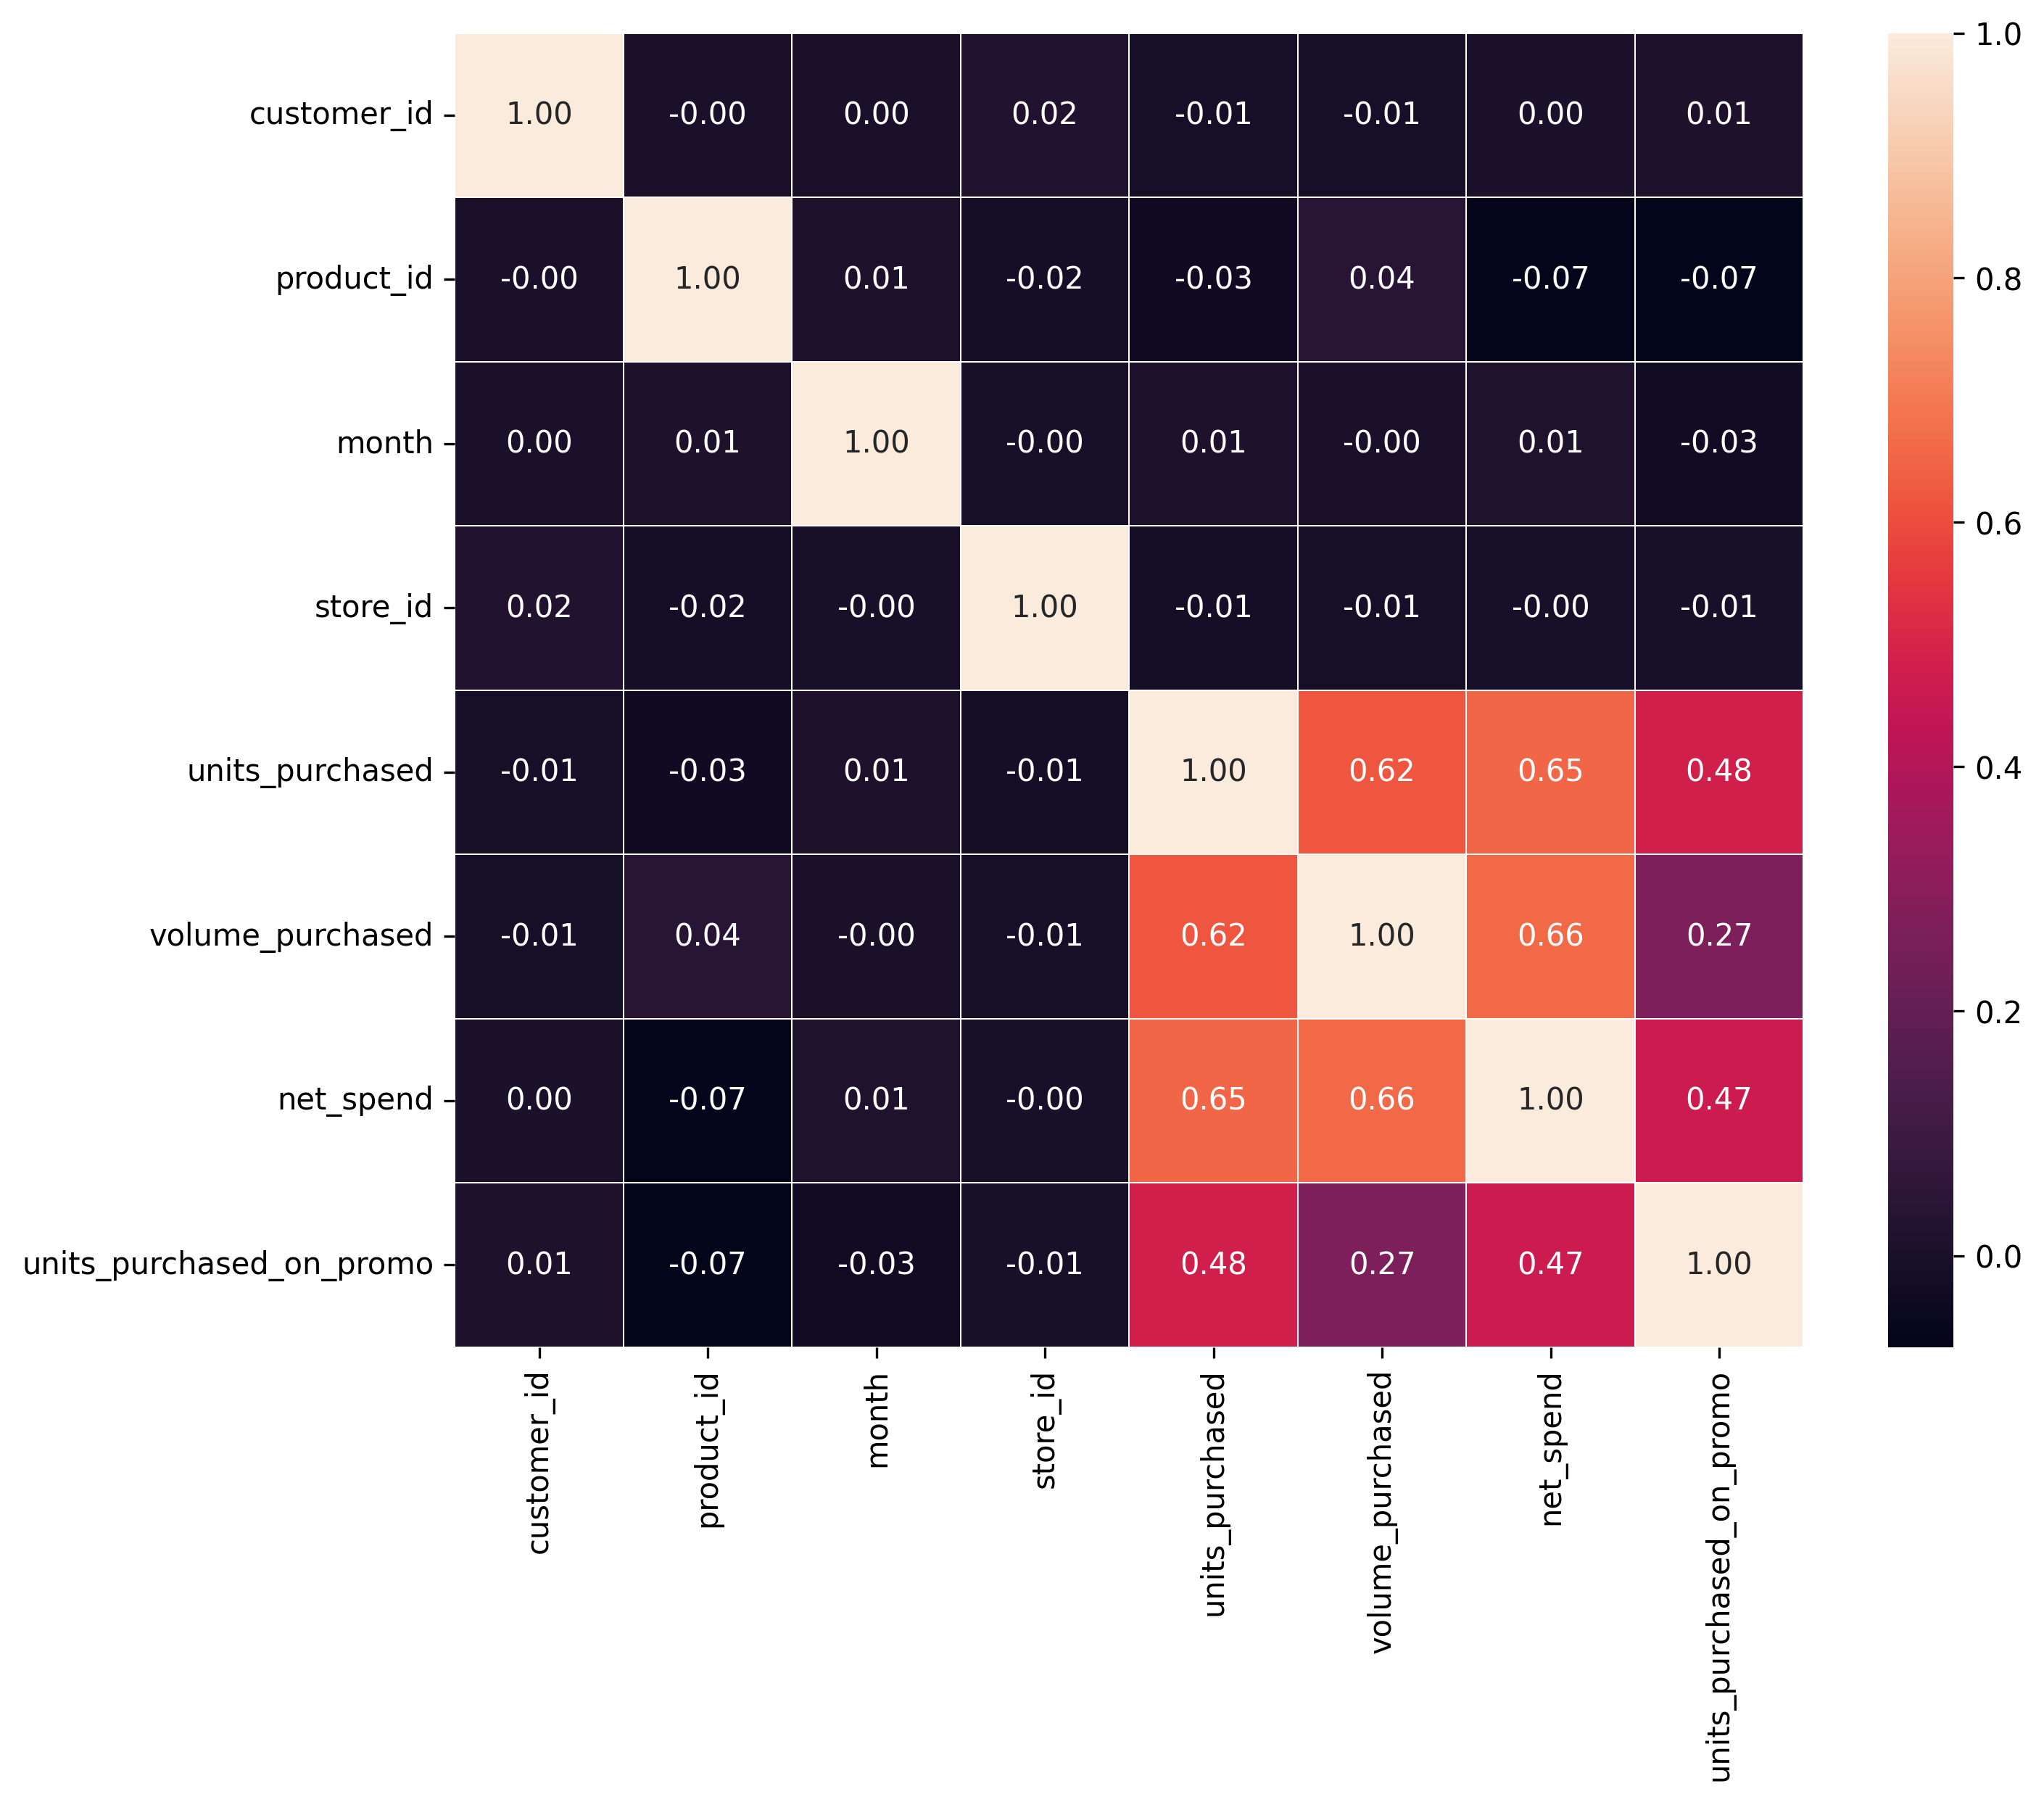

In [ ]:
plt.figure(figsize=(10, 8), dpi = 300)
sns.heatmap(sales.corr(method = 'pearson'), annot=True, fmt=".2f", linewidth=.1)
plt.show()

### **MERGE DATASETS**

**Dataset**

In [ ]:
data = sales.merge(customers, 
                   on='customer_id', how='left').merge(products, 
                                                       on='product_id', how='left').merge(stores, 
                                                                                          on='store_id', how='left')
data['date'] = pd.to_datetime(dict(year=2023, month=data.month, day=1))
data['revenue'] = data.units_purchased*data.net_spend
print('Date Shape: {}'.format(data.shape))

data.head(10)

Date Shape: (68136, 21)


customer_id  product_id  month  store_id  units_purchased  \
0          100         545     11      1670                1   
1          100         549     12      1670                1   
2          100         763      3       604                1   
3          100        1293      4      1178                1   
4          100          74      7       249                1   
5          100          74      7       294                1   
6          100         763      9       604                1   
7        10008         394     10       241                1   
8        10008          91     10       241                2   
9        10008        1081     11       241                1   

   volume_purchased  net_spend  units_purchased_on_promo     qualification  \
0             0.750       1.10                         0  Degree or higher   
1             1.000       1.20                         0  Degree or higher   
2             0.500       0.70                         0  Degree or higher   
3             0.500       0.55                         0  Degree or higher   
4             0.415       1.24                         1  Degree or higher   
5             0.415       1.25                         1  Degree or higher   
6             0.500       0.70                         0  Degree or higher   
7             0.720       3.00                         1  Degree or higher   
8             1.200       4.00                         2  Degree or higher   
9             0.500       2.00                         1  Degree or higher   

    age  ...          tenure retired_flag   income  brand_id  K_flag  \
0  55.0  ...  Owned outright          0.0  50000.0        49   False   
1  55.0  ...  Owned outright          0.0  50000.0        49   False   
2  55.0  ...  Owned outright          0.0  50000.0        62   False   
3  55.0  ...  Owned outright          0.0  50000.0        68   False   
4  55.0  ...  Owned outright          0.0  50000.0        70   False   
5  55.0  ...  Owned outright          0.0  50000.0        70   False   
6  55.0  ...  Owned outright          0.0  50000.0        62   False   
7  34.0  ...       Mortgaged          0.0  20000.0        67    True   
8  34.0  ...       Mortgaged          0.0  20000.0        70   False   
9  34.0  ...       Mortgaged          0.0  20000.0        67    True   

   store_group  store_size  store_region       date revenue  
0           34           2         North 2023-11-01    1.10  
1           34           2         North 2023-12-01    1.20  
2           41           2         North 2023-03-01    0.70  
3            6           2         North 2023-04-01    0.55  
4           28           2         North 2023-07-01    1.24  
5            8           2         North 2023-07-01    1.25  
6           41           2         North 2023-09-01    0.70  
7            8           4        London 2023-10-01    3.00  
8            8           4        London 2023-10-01    8.00  
9            8           4        London 2023-11-01    2.00  

[10 rows x 21 columns]

In [ ]:
reduce_mem_usage(data)

100%|██████████| 21/21 [00:00<00:00, 760.80it/s]



Memory Usage After Optimization: 4.35 MB
Decreased By: 54.7%



**About Data**

In [ ]:
print("Number of Duplicates: {}".format(len(data[data.duplicated()])))

Number of Duplicates: 0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68136 entries, 0 to 68135
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               68136 non-null  int16         
 1   product_id                68136 non-null  int16         
 2   month                     68136 non-null  int8          
 3   store_id                  68136 non-null  int16         
 4   units_purchased           68136 non-null  int8          
 5   volume_purchased          68136 non-null  float16       
 6   net_spend                 68136 non-null  float16       
 7   units_purchased_on_promo  68136 non-null  int8          
 8   qualification             46661 non-null  object        
 9   age                       46661 non-null  float16       
 10  child                     46661 non-null  float16       
 11  tenure                    46661 non-null  object        
 12  retired_flag      

In [ ]:
data.describe()

customer_id    product_id         month      store_id  \
count  68136.000000  68136.000000  68136.000000  68136.000000   
mean   11294.881311    849.668575      6.456455    975.024950   
std     6568.495736    466.381239      3.425438    573.193959   
min       11.000000     30.000000      1.000000      3.000000   
25%     5545.000000    450.000000      4.000000    486.000000   
50%    11102.000000    877.000000      7.000000    948.000000   
75%    17165.000000   1256.000000      9.000000   1465.000000   
max    22607.000000   1646.000000     12.000000   2012.000000   

       units_purchased  volume_purchased     net_spend  \
count     68136.000000      68136.000000  68136.000000   
mean          1.408697          0.000000           NaN   
std           1.049617          0.000000      0.000000   
min           1.000000          0.049988      0.000000   
25%           1.000000          0.454102      1.099609   
50%           1.000000          0.674805      1.900391   
75%           1.000000          1.000000      2.699219   
max          35.000000         15.000000     39.500000   

       units_purchased_on_promo         age         child  retired_flag  \
count              68136.000000  46661.0000  46661.000000  46661.000000   
mean                   0.577815         inf      0.840820      0.180420   
std                    0.954620     16.0625      1.077148      0.384521   
min                    0.000000     22.0000      0.000000      0.000000   
25%                    0.000000     40.0000      0.000000      0.000000   
50%                    0.000000     50.0000      0.000000      0.000000   
75%                    1.000000     64.0000      2.000000      0.000000   
max                   35.000000    138.0000      5.000000      1.000000   

        income      brand_id   store_group    store_size       revenue  
count  46661.0  68136.000000  68136.000000  68136.000000  68136.000000  
mean       inf     53.919749     40.373562      3.134863           NaN  
std        inf     17.750649     20.141878      1.337361           NaN  
min        0.0     26.000000      1.000000      1.000000      0.000000  
25%    20000.0     31.000000     29.000000      2.000000      1.150391  
50%    30000.0     62.000000     43.000000      3.000000      2.000000  
75%    40000.0     68.000000     52.000000      4.000000      3.400391  
max    60000.0     76.000000     78.000000     10.000000    980.000000

## **FORECASTING**

**REFERENCE**: [GeeksForGeeks](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

  0%|          | 0/200 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22.895, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43.199, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=21.295, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=23.285, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16.813, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.644, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.714 seconds


  0%|          | 1/200 [00:02<06:50,  2.06s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.150, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=35.019, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.229, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.705, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=30.225, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31.588, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=30.890, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=26.138, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24.473, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.691, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.346, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22.558, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.547, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1

  1%|          | 2/200 [00:03<05:54,  1.79s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25.237, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-57.986, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-55.987, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-56.000, Time=0.10 sec


  2%|▏         | 3/200 [00:04<04:32,  1.38s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-53.989, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.776 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18.319, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30.981, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=17.793, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=24.930, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18.456, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13.384, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.380, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13.297, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15.293, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.562 seconds


  2%|▏         | 4/200 [00:05<03:38,  1.11s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.994, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.430, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=41.435, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=35.019, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26.976, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.033, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=26.861, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.628 seconds


  2%|▎         | 5/200 [00:06<03:15,  1.00s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=42.121, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.852, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.561, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.003, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=43.688, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=43.611, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=54.731, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42.337, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=45.584, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=38.189, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=36.189, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.236, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=36.189, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.792 seconds


  3%|▎         | 6/200 [00:07<03:12,  1.01it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=73.156, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=70.883, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=73.396, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=67.157, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=68.847, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=63.164, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=61.354, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=61.079, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=61.726, Time=0.03 sec


  4%|▎         | 7/200 [00:07<03:07,  1.03it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=63.206, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.761 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=58.870, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=68.607, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.999, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=66.321, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=60.259, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=59.852, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=58.328, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=60.260, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=56.610, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=54.765, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.768, Time

  4%|▍         | 8/200 [00:09<03:18,  1.04s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50.021, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.692, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48.207, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=50.197, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=51.565, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.466, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=47.524, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=46.240, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=44.688, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=46.658, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=46.285, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=45.890, Time=0.07 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.656 seconds


  4%|▍         | 9/200 [00:09<03:02,  1.05it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71.119, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=56.440, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=64.335, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=57.617, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=47.735, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.829, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47.434, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.533 seconds


  5%|▌         | 10/200 [00:10<02:49,  1.12it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=79.114, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=84.325, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=79.151, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=82.167, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=82.682, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=80.381, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=76.817, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=74.855, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=72.956, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=74.879, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.962 seconds


  6%|▌         | 11/200 [00:11<03:01,  1.04it/s]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.328, Time=0.01 sec
Total fit time: 0.013 seconds


  6%|▌         | 12/200 [00:12<02:19,  1.35it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29.527, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.995, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30.696, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=37.558, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31.172, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=34.489, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=32.395, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=26.297, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24.445, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.499, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24.490, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.904 seconds


  6%|▋         | 13/200 [00:13<02:43,  1.15it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.939, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16.123, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=29.640, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=15.477, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=16.456, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8.136, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6.289, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4.398, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6.252, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.144 seconds


  7%|▋         | 14/200 [00:15<04:18,  1.39s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=40.003, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.875, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.556, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=40.724, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.744, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=40.703, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=41.635, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=38.250, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.858, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.225, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.049, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.352, Time=0.20 sec

Best 

  8%|▊         | 15/200 [00:17<05:00,  1.62s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26.314, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.176, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.480, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=39.947, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=27.857, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27.997, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29.733, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22.633, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20.735, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19.357, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21.054, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.831 seconds


  8%|▊         | 16/200 [00:18<04:21,  1.42s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.033, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41.353, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.161, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42.167, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=34.354, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32.777, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.565, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.633 seconds


  8%|▊         | 17/200 [00:19<03:48,  1.25s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=39.048, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48.559, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=38.060, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=44.962, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.580, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=40.759, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=34.061, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32.130, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.990, Time=0.03 sec


  9%|▉         | 18/200 [00:20<03:14,  1.07s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.507 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.743, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29.340, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35.063, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29.292, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=29.868, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28.142, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20.029, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=19.312, Time=0.12 sec
 A

 10%|▉         | 19/200 [00:22<03:53,  1.29s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44.019, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=46.959, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=45.723, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.863, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.872, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39.849, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.586 seconds


 10%|█         | 20/200 [00:22<03:25,  1.14s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.881, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39.303, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50.098, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=40.593, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.290, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30.382, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32.227, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34.127, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.579 seconds


 10%|█         | 21/200 [00:23<03:04,  1.03s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=47.363, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52.296, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.168, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=48.834, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=48.570, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=49.360, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.781, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.290, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.103, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46.877, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=45.800, Time=0.05 sec


 11%|█         | 22/200 [00:24<02:47,  1.06it/s]

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.573 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.552, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=37.585, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=58.964, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31.718, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=33.550, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=33.165, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=34.195, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=32.494, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=34.764, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=27.449, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=25.785, Time=0.

 12%|█▏        | 23/200 [00:26<03:20,  1.13s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=49.705, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.457, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.625, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=52.974, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=50.706, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.409, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.580, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.344, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46.694, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.451 seconds


 12%|█▏        | 24/200 [00:26<02:55,  1.00it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.095, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.195, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.814, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=50.427, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.478, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41.877, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.638 seconds


 12%|█▎        | 25/200 [00:27<02:48,  1.04it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.553, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.925, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=52.070, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=49.482, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=46.572, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=48.521, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=49.190, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=44.879, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=43.817, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=42.524, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41.224, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.286, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.39

 13%|█▎        | 26/200 [00:29<03:28,  1.20s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=72.215, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=66.232, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=69.311, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=67.343, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.390, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.529, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.519, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.229 seconds


 14%|█▎        | 27/200 [00:31<03:55,  1.36s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=49.425, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.864, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52.048, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.137, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.437, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=49.984, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.823, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=43.959, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.333, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.892, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.782 seconds


 14%|█▍        | 28/200 [00:33<04:39,  1.62s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=43.186, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.116, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41.281, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=52.667, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.185, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=44.902, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.563, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.971, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=38.912, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.333, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.620, Time=0.03 sec


 14%|█▍        | 29/200 [00:34<03:53,  1.36s/it]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.585 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.929, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59.016, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61.567, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=56.113, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=57.350, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.116, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.116, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=48.289, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.116, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

 15%|█▌        | 30/200 [00:35<03:44,  1.32s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41.194, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=45.335, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=41.088, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=39.240, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=41.133, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=35.552, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=33.730, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.528, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30.954, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32.248, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.923 s

 16%|█▌        | 31/200 [00:36<03:34,  1.27s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42.828, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29.588, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29.574, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=27.783, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=27.211, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20.513, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=19.801, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=18.179, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18.750, Time=0.03 sec
 ARIMA(1,0,1)(0

 16%|█▌        | 32/200 [00:38<04:15,  1.52s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=34.331, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.163, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=35.994, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50.820, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=35.997, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=34.691, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec


 16%|█▋        | 33/200 [00:39<03:54,  1.40s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.936 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.738, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.059, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61.214, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=57.394, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=58.177, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49.804, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.971, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=47.730, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48.473, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

 17%|█▋        | 34/200 [00:40<03:36,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=42.731, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.914, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41.455, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=44.287, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.443, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=45.177, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38.393, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.346, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.564, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.332, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.355 seconds


 18%|█▊        | 35/200 [00:41<02:56,  1.07s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21.344, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38.247, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=23.723, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32.125, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23.063, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23.085, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=21.575, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25.062, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16.621, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15.395, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13.544, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15.403, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.854 seconds


 18%|█▊        | 36/200 [00:42<02:55,  1.07s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22.691, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.486, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=20.701, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=22.694, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17.783, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.526, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17.958, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19.779, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.644 seconds


 18%|█▊        | 37/200 [00:43<02:43,  1.00s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15.435, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.080, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19.319, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32.120, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=17.404, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=17.394, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=30.746, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18.690, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10.150, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9.019, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7.236, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9.073, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.439 seconds


 19%|█▉        | 38/200 [00:46<04:14,  1.57s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67.854, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=69.124, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=69.299, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.442, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.149, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=65.989, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.870 seconds


 20%|█▉        | 39/200 [00:47<04:02,  1.51s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.142, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.688, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61.891, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=60.533, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=62.625, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.679, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50.758, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.205, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.532, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.986 seconds


 20%|██        | 40/200 [00:48<03:53,  1.46s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.518, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=21.980, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35.791, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=20.046, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=21.445, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20.100, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=22.011, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13.722, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11.722, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9.966, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11.715, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13.678, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.877 seconds


 20%|██        | 41/200 [00:50<03:44,  1.41s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=38.570, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43.862, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=37.191, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=37.954, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.965, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=40.167, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35.228, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.491, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.706, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=35.616, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


 21%|██        | 42/200 [00:51<03:21,  1.28s/it]

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.798 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=69.101, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=69.868, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=69.961, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=70.650, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=69.233, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=69.414, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=67.849, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=68.898, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=70.878, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=67.316, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.867, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.135, Time

 22%|██▏       | 43/200 [00:51<03:01,  1.15s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.711 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.581, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.645, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=53.684, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42.484, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=43.559, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=41.787, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=40.464, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(

 22%|██▏       | 44/200 [00:54<03:48,  1.46s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.701, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39.426, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=47.846, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=40.054, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33.124, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31.126, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.124, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.638 seconds


 22%|██▎       | 45/200 [00:55<03:17,  1.28s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.631, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.042, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30.589, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.054, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.453, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33.437, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26.043, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.046, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=26.125, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28.039, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.488 seconds


 23%|██▎       | 46/200 [00:55<02:47,  1.09s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52.893, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=37.652, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.396, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.675, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.699, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.756 seconds


 24%|██▎       | 47/200 [00:56<02:42,  1.06s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=30.832, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.273, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=28.938, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=39.181, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=30.927, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=32.689, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.401, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.622, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21.615, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23.452, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.390 seconds


 24%|██▍       | 48/200 [00:57<02:21,  1.08it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.886, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30.281, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=39.321, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29.120, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=29.500, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=21.237, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19.778, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18.332, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19.443, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.997 seconds


 24%|██▍       | 49/200 [00:58<02:36,  1.03s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.823, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=32.161, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=37.385, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=32.085, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=32.595, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=30.649, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31.764, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.653 seconds


 25%|██▌       | 50/200 [01:01<04:08,  1.65s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18.370, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.866, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=23.735, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32.707, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11.373, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13.200, Time=0.47 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13.343, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16.206, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15.193, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8.940, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10.968, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6.970, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11.407, Time=0.03 sec
 ARIM

 26%|██▌       | 51/200 [01:04<05:15,  2.12s/it]

 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=9.114, Time=0.33 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 3.035 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=27.597, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42.174, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.550, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35.116, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27.611, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29.566, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23.259, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.878, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=23.499, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=25.258, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.408 seconds


 26%|██▌       | 52/200 [01:05<04:05,  1.66s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21.136, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.666, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=22.650, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=45.360, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23.125, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23.124, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=22.245, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16.492, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14.514, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.583, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14.519, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.939 seconds


 26%|██▋       | 53/200 [01:06<03:42,  1.51s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.083, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.022, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39.653, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42.558, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=41.650, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42.860, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33.804, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31.837, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.042, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34.504, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.585 seconds


 27%|██▋       | 54/200 [01:07<03:09,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=37.596, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.097, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=35.726, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.524, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=37.653, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=39.669, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33.883, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31.883, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.883, Time=0.04 sec


 28%|██▊       | 55/200 [01:08<02:41,  1.12s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.516 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.969, Time=0.01 sec
Total fit time: 0.015 seconds


 28%|██▊       | 56/200 [01:08<02:03,  1.17it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.844, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.400, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=58.912, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52.115, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=53.723, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=53.548, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=55.537, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.322 seconds


 28%|██▊       | 57/200 [01:08<01:51,  1.28it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38.159, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-48.164, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-46.165, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-46.164, Time=0.07 sec


 29%|██▉       | 58/200 [01:09<01:57,  1.21it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-44.190, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=45.224, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=37.178, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=41.423, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=35.858, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=36.548, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=30.193, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28.615, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=27.129, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28.479, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16

 30%|██▉       | 59/200 [01:11<02:10,  1.08it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=52.136, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.983, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53.454, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=54.590, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53.531, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=53.268, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=54.711, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=52.782, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=55.180, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.002, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48.079, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.530, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.013, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.565 seconds


 30%|███       | 60/200 [01:11<02:02,  1.14it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=36.357, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=66.570, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.646, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=38.160, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=37.778, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.433, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.790 seconds


 30%|███       | 61/200 [01:12<02:08,  1.08it/s]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32.121, Time=0.02 sec
Total fit time: 0.018 seconds


 31%|███       | 62/200 [01:13<01:41,  1.36it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9.352, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=33.889, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12.757, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=26.928, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11.238, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11.236, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=24.836, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11.260, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13.326, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5.349, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3.362, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1.383, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3.360, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.520 seconds


 32%|███▏      | 63/200 [01:15<02:27,  1.08s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.657, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48.789, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55.434, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.265, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=40.824, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=35.629, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=33.629, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.154, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=31.644, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35.218, Time=0.05 sec
 ARIMA(3,0,0

 32%|███▏      | 64/200 [01:18<04:18,  1.90s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63.862, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53.561, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.918, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=55.104, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.205, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=44.350, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.761 seconds


 32%|███▎      | 65/200 [01:20<03:47,  1.68s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.814, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48.055, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.447, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=47.751, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=39.375, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.970, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.517, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.362, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.849 seconds


 33%|███▎      | 66/200 [01:21<03:20,  1.50s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.640, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.328, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=31.116, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.798, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33.098, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26.119, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24.697, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=26.043, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27.870, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.612 seconds


 34%|███▎      | 67/200 [01:21<02:50,  1.29s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.383, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.168, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=36.346, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27.102, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17.258, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15.273, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17.228, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18.877, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.690 seconds


 34%|███▍      | 68/200 [01:22<02:37,  1.20s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=43.274, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.563, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42.428, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=48.414, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.040, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=44.934, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38.662, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.684, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.660, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=40.659, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.412 seconds


 34%|███▍      | 69/200 [01:23<02:13,  1.02s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40.975, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18.055, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=33.152, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17.488, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=17.762, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8.603, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7.292, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5.558, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7.084, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.083 seconds


 35%|███▌      | 70/200 [01:24<02:25,  1.12s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63.849, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-19.263, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-17.243, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-17.263, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.665 seconds


 36%|███▌      | 71/200 [01:25<02:15,  1.05s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=48.825, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.150, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.576, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.723, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=49.287, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.632, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.094, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.097, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.081, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.520 seconds


 36%|███▌      | 72/200 [01:26<02:06,  1.01it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=34.625, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.520, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=38.915, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49.715, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=34.975, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=33.090, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=34.870, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=36.318, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.129, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28.412, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.965, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28.627, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29.876, Time=0.08 sec

Be

 36%|███▋      | 73/200 [01:27<02:10,  1.03s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=63.131, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67.039, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=65.864, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=63.131, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=67.077, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=64.562, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.639 seconds


 37%|███▋      | 74/200 [01:28<02:11,  1.04s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=42.064, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.099, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.108, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42.094, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=43.204, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35.435, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.491, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.516, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=35.310, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=36.047, Time=0.51 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.312 seconds


 38%|███▊      | 75/200 [01:30<02:31,  1.21s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.238, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19.936, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=47.697, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16.034, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19.859, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=17.347, Time=0.61 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=19.252, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8.850, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7.154, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5.544, Time=0.10 sec
 ARIMA(0,0,0)(0

 38%|███▊      | 76/200 [01:34<04:27,  2.15s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5.054, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.517, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2.285, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=nan, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.592 seconds


 38%|███▊      | 77/200 [01:36<04:12,  2.05s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48.328, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.459, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=34.697, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=25.202, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23.226, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.708 seconds


 39%|███▉      | 78/200 [01:37<03:31,  1.74s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=46.085, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.109, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=46.938, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.255, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=47.994, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=47.999, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=46.355, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=49.986, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.121, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.161, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40.577, Time=0.02 sec


 40%|███▉      | 79/200 [01:38<02:59,  1.48s/it]

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=42.127, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=62.844, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=68.585, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=61.630, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=66.906, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=63.333, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=64.838, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=60.242, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=58.769, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60.369, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.240, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.409 seconds


 40%|████      | 80/200 [01:38<02:25,  1.21s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48.316, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.893, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=46.138, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.840, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=39.866, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=40.012, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=41.856, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=34.956, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.961, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31.351, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32.981, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34.957, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.555 seconds


 40%|████      | 81/200 [01:39<02:10,  1.10s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21.567, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.770, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25.008, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.406, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23.557, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23.554, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=24.364, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25.566, Time=0.13 sec


 41%|████      | 82/200 [01:40<02:06,  1.07s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.830 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=70.062, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.807, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.806, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53.655, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.086, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.963, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.901, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.768, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 

 42%|████▏     | 83/200 [01:41<02:07,  1.09s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.147, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51.690, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=54.962, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53.066, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.918, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.035, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=46.876, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=48.838, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.473 seconds


 42%|████▏     | 84/200 [01:42<01:54,  1.02it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.832, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59.648, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=62.683, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=60.606, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49.918, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.397, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.640 seconds


 42%|████▎     | 85/200 [01:43<01:50,  1.04it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.070, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=60.824, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=62.666, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=57.542, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=59.515, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=53.482, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51.488, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=51.297, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.953 seconds


 43%|████▎     | 86/200 [01:45<02:07,  1.12s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55.609, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30.275, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.725, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.283, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.345, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.588 seconds


 44%|████▎     | 87/200 [01:47<02:38,  1.40s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50.656, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.053, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54.523, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=60.268, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=52.405, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=59.942, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=54.303, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.257, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=43.757, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.392, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.775, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.045 seconds


 44%|████▍     | 88/200 [01:49<03:13,  1.73s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50.727, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.411, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52.615, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.528, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53.121, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=52.727, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.123, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.735 seconds


 44%|████▍     | 89/200 [01:50<02:46,  1.50s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=77.615, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=70.305, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=72.035, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=64.870, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=62.872, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=64.827, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.547 seconds


 45%|████▌     | 90/200 [01:51<02:27,  1.34s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.089, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52.878, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.067, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53.877, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.105, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.381, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.788, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.616 seconds


 46%|████▌     | 91/200 [01:52<02:10,  1.20s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=69.107, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=74.603, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=70.287, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=72.253, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=71.032, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=69.619, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=74.053, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=71.136, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.589 seconds


 46%|████▌     | 92/200 [01:53<01:57,  1.09s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21.630, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.673, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24.318, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23.603, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23.583, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=23.685, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25.605, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17.106, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15.121, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13.123, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15.121, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.013 seconds


 46%|████▋     | 93/200 [01:54<02:01,  1.14s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=70.583, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=83.649, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=69.530, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=70.425, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=72.412, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67.788, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=67.746, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=68.028, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=69.752, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.335 seconds


 47%|████▋     | 94/200 [01:55<01:41,  1.05it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=34.835, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15.018, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=28.043, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14.372, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=15.352, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13.466, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=15.456, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13.482, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7.745, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5.987, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5.148, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3.294, Time=0.04 sec
 ARIMA(1,0

 48%|████▊     | 95/200 [01:57<02:19,  1.33s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.159, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=50.011, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55.458, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=50.659, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.296, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.523, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.309, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.295, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.505 seconds


 48%|████▊     | 96/200 [01:58<02:00,  1.16s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.731, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=60.143, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=63.936, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=58.969, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=59.439, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51.715, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.020, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.167, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=49.536, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.983 seconds


 48%|████▊     | 97/200 [01:59<02:01,  1.18s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=48.148, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.745, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52.008, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.006, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=45.060, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.070, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=45.062, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=47.051, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=41.934, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.394, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=43.792, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=43.806, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.899, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=44.271, Time=0.51 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time

 49%|████▉     | 98/200 [02:01<02:35,  1.52s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18.114, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.490, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16.546, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18.492, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20.512, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13.398, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11.403, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13.395, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15.383, Time=0.36 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.516 seconds


 50%|████▉     | 99/200 [02:03<02:50,  1.69s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=58.252, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=72.538, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=60.262, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=68.094, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=59.840, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=66.388, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=59.204, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=61.822, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.857, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.886, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=51.148, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.930, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.443 seconds


 50%|█████     | 100/200 [02:05<02:57,  1.77s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=36.519, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.023, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39.716, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50.695, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=37.194, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.482, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.385 seconds


 50%|█████     | 101/200 [02:08<03:28,  2.11s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=37.656, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.313, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.106, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.469, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=39.515, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=39.582, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=41.492, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.023, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=41.268, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34.745, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.028, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31.300, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.965, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.237 seconds


 51%|█████     | 102/200 [02:10<03:10,  1.94s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=43.314, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.000, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=43.124, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51.378, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.011, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=45.007, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=45.009, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=40.755, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38.809, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.549, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.929, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=40.792, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.593 seconds


 52%|█████▏    | 103/200 [02:10<02:34,  1.59s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.295, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52.784, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44.765, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50.484, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=41.928, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=42.620, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=47.704, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=40.290, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=42.105, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=43.480, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=36.930, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=36.100, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.526, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=36.255, Time=0.03 sec


 52%|█████▏    | 104/200 [02:11<02:17,  1.44s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37.417, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.876 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=34.426, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.328, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=36.804, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=45.206, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=36.144, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=36.167, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=34.657, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=38.144, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29.704, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28.477, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.625, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28.485, T

 52%|█████▎    | 105/200 [02:13<02:22,  1.50s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67.794, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51.338, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61.358, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.502, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=42.056, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40.665, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.679 seconds


 53%|█████▎    | 106/200 [02:14<02:06,  1.34s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9.261, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.923, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11.259, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11.355, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=0.572, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=0.121, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1.733, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=0.157, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.209 seconds


 54%|█████▎    | 107/200 [02:16<02:08,  1.39s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67.404, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54.082, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=63.042, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=54.438, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.948, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.191, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.668 seconds


 54%|█████▍    | 108/200 [02:17<01:55,  1.26s/it]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42.348, Time=0.01 sec
Total fit time: 0.014 seconds


 55%|█████▍    | 109/200 [02:17<01:28,  1.03it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45.340, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.123, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48.172, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=46.779, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=46.534, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=46.614, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.935, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=40.177, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38.397, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.114, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.783 seconds


 55%|█████▌    | 110/200 [02:18<01:28,  1.02it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15.178, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.600, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=17.365, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=31.323, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=17.178, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=27.464, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=15.781, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19.048, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=11.355, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9.372, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7.461, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9.382, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.052 seconds


 56%|█████▌    | 111/200 [02:20<02:05,  1.41s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.916, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44.700, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.185, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=41.625, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=37.786, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=36.060, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=34.341, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=33.558, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=34.046, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.481 seconds

 56%|█████▌    | 112/200 [02:23<02:45,  1.88s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=38.658, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.355, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.300, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=47.589, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=40.607, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=40.475, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=46.616, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=40.990, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=42.492, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.714 seconds


 56%|█████▋    | 113/200 [02:24<02:19,  1.61s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.025, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24.285, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=37.766, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=23.642, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=24.615, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16.437, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14.561, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.652, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14.535, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.021 seconds


 57%|█████▋    | 114/200 [02:25<02:10,  1.51s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14.774, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22.733, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15.338, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=21.017, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16.763, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16.759, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16.065, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.999 seconds


 57%|█████▊    | 115/200 [02:27<02:00,  1.42s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45.651, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53.368, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44.000, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49.755, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=45.750, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.682, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39.760, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=40.662, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=42.588, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.419 seconds


 58%|█████▊    | 116/200 [02:27<01:39,  1.19s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26.670, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28.946, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25.100, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23.247, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21.490, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


 58%|█████▊    | 117/200 [02:28<01:24,  1.02s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23.578, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.579 seconds
ERROR: 1246
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.158, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41.264, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42.478, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.202, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.306, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=42.558, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total f

 59%|█████▉    | 118/200 [02:29<01:26,  1.06s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=54.702, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.810, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.770, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=60.547, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53.754, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=54.701, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=55.670, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=53.537, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=51.195, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49.460, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=47.471, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=48.560, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49.464, Time=0.08 sec
 AR

 60%|█████▉    | 119/200 [02:30<01:31,  1.13s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45.860, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.299, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=46.381, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.779, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=46.707, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=46.886, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=46.259, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=34.982, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.993, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38.418, Time=0.02 sec
 ARIMA(0,0,2

 60%|██████    | 120/200 [02:35<02:56,  2.20s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.776, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29.951, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=39.354, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29.047, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=28.846, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=29.967, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=24.821, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=23.184, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21.336, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19.549, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21.291, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.268 s

 60%|██████    | 121/200 [02:38<03:06,  2.37s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6.041, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40.605, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4.041, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6.041, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8.041, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2.670, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.527, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4.539, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4.569, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7.710, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.129 seconds


 61%|██████    | 122/200 [02:39<02:40,  2.06s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.257, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.068, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42.780, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=40.373, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33.035, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=31.356, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32.574, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.581 seconds


 62%|██████▏   | 123/200 [02:40<02:11,  1.70s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=28.429, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.032, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.573, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=28.491, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29.740, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.447, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.478, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.861 seconds


 62%|██████▏   | 124/200 [02:41<01:55,  1.51s/it]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=33.261, Time=0.02 sec
Total fit time: 0.024 seconds


 62%|██████▎   | 125/200 [02:41<01:26,  1.15s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46.141, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=37.351, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.424, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=36.001, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=37.233, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.212, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.850, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26.661, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.978 seconds


 63%|██████▎   | 126/200 [02:43<01:32,  1.25s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.022, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=22.417, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=21.257, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=22.323, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=21.824, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13.373, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11.915, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10.468, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.140 seconds


 64%|██████▎   | 127/200 [02:44<01:35,  1.31s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.655, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=17.913, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14.986, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12.232, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12.629, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.983 seconds


 64%|██████▍   | 128/200 [02:46<01:33,  1.29s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=46.823, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.837, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51.896, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.925, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42.924, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=41.441, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=43.109, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=44.912, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=39.064, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.813, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=41.064, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=41.063, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.396, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=43.060, Time=0.16 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time

 64%|██████▍   | 129/200 [02:47<01:27,  1.23s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.275, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.564, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=33.160, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=34.288, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=27.836, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=25.954, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24.032, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=25.932, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.958 seconds


 65%|██████▌   | 130/200 [02:48<01:27,  1.25s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.468, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=22.751, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=24.327, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15.077, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13.101, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14.682, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.907 seconds


 66%|██████▌   | 131/200 [02:49<01:29,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=23.858, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.280, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.524, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32.274, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25.854, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25.853, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=30.393, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26.369, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=27.859, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19.973, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18.782, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.923, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18.813, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.855 seconds


 66%|██████▌   | 132/200 [02:53<02:07,  1.88s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.829, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.726, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=32.210, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.564, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29.898, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27.899, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=29.898, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31.423, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=27.409, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28.939, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=29.400, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=29.407, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.036, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=31.004, Time=0.24 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time

 66%|██████▋   | 133/200 [02:55<02:10,  1.95s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=35.995, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.383, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=37.661, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50.421, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=37.848, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=35.933, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=37.873, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32.483, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=30.514, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28.654, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30.526, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=32.508, Time=0.10 sec

Best 

 67%|██████▋   | 134/200 [02:56<01:56,  1.77s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22.011, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52.552, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=23.840, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=45.278, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=22.935, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22.516, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=41.189, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=24.914, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17.884, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16.361, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=14.541, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16.234, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.871 seconds


 68%|██████▊   | 135/200 [02:57<01:41,  1.57s/it]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.819, Time=0.02 sec
Total fit time: 0.023 seconds


 68%|██████▊   | 136/200 [02:58<01:16,  1.19s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27.542, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=27.046, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=27.753, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=28.301, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21.394, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20.254, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.692 seconds


 68%|██████▊   | 137/200 [02:59<01:15,  1.20s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=66.172, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=70.404, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=64.541, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=65.272, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=66.537, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=67.721, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=62.119, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=60.718, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60.739, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.384, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.305 seconds


 69%|██████▉   | 138/200 [02:59<01:03,  1.02s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=40.649, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.416, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39.163, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49.834, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=40.409, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35.317, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.206, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=35.519, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37.315, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.475 seconds


 70%|██████▉   | 139/200 [03:00<00:56,  1.08it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40.951, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=21.113, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=34.596, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=20.458, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=21.431, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12.832, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11.023, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9.157, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10.970, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.980 seconds


 70%|███████   | 140/200 [03:01<01:02,  1.05s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=55.247, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63.757, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53.871, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=59.691, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=55.452, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=57.241, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.542, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50.681, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.592, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.456, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.389 seconds


 70%|███████   | 141/200 [03:02<00:54,  1.09it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55.317, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=43.298, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51.611, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=41.466, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28.590, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=30.410, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=30.185, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=29.798, Time=0.27 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.711 seconds


 71%|███████   | 142/200 [03:04<01:14,  1.28s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13.126, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.506, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11.206, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13.153, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15.168, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7.958, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5.965, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7.955, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.034 seconds


 72%|███████▏  | 143/200 [03:07<01:36,  1.70s/it]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24.625, Time=0.02 sec
Total fit time: 0.023 seconds


 72%|███████▏  | 144/200 [03:07<01:16,  1.37s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46.132, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29.823, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.390, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.368, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33.739, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23.247, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21.329, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22.990, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.392, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.997 seconds


 72%|███████▎  | 145/200 [03:09<01:17,  1.42s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43.959, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=32.203, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=40.005, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29.359, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=27.725, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28.356, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=22.779, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21.398, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19.456, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19.306, Time=0.03 sec
 ARIMA(1,0,0

 73%|███████▎  | 146/200 [03:11<01:21,  1.51s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=48.698, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.323, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.352, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=53.553, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=49.162, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.089, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.107, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.056, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.030, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.989, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.452 seconds


 74%|███████▎  | 147/200 [03:11<01:07,  1.27s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50.550, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=69.881, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54.874, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=64.491, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.270, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=49.598, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=51.443, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=45.932, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.305, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.445, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.357, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.426, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.735 seconds


 74%|███████▍  | 148/200 [03:12<01:00,  1.17s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=49.179, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63.633, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.958, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.288, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=51.169, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=51.078, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.401, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.809, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.172, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.192, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.184, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.882 seconds


 74%|███████▍  | 149/200 [03:14<01:01,  1.21s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=40.480, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.617, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=43.156, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42.319, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=41.622, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=48.157, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.244, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.716 seconds


 75%|███████▌  | 150/200 [03:15<00:57,  1.15s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.594, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.390, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50.170, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=45.621, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=34.857, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=33.818, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=37.788, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.687 seconds


 76%|███████▌  | 151/200 [03:16<00:54,  1.11s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=66.100, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=63.236, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=65.088, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=64.186, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56.619, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.918, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=58.908, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.554 seconds


 76%|███████▌  | 152/200 [03:17<00:49,  1.04s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=43.276, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.197, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=43.073, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=53.169, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.212, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=44.516, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38.228, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.850, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.522, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=40.194, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.510 seconds


 76%|███████▋  | 153/200 [03:17<00:45,  1.04it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18.732, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=43.112, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16.812, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18.759, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20.682, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13.564, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11.571, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13.560, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds


 77%|███████▋  | 154/200 [03:18<00:45,  1.01it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=54.182, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.694, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=55.312, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=58.310, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=51.637, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=49.677, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=51.593, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=53.390, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49.451, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51.134, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=51.159, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=51.346, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=51.979, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1

 78%|███████▊  | 155/200 [03:20<00:59,  1.32s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.687, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.728, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=31.935, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=44.486, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33.062, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=33.479, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.304, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=33.283, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=35.001, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28.546, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26.820, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.361, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=26.969, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28.737, Time=0.22 sec


 78%|███████▊  | 156/200 [03:23<01:07,  1.54s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.826, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=35.975, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=46.394, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=36.344, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24.938, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23.624, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27.347, Time=0.30 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.531 seconds


 78%|███████▊  | 157/200 [03:24<01:11,  1.66s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20.623, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.468, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=22.751, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32.225, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=22.601, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22.601, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=30.686, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=22.689, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.946 seconds


 79%|███████▉  | 158/200 [03:26<01:04,  1.53s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=73.033, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=69.233, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=71.024, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=71.072, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.506, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=63.518, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=65.476, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67.303, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.497 seconds


 80%|███████▉  | 159/200 [03:26<00:53,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4.201, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32.095, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6.200, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4.201, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2.216, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8.136, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=0.897, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6.293, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6.249, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3.531, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6.123, Time=0.22 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.004 seconds


 80%|████████  | 160/200 [03:28<00:51,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=82.076, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=82.229, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=82.899, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=76.404, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=78.243, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=78.180, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.343 seconds


 80%|████████  | 161/200 [03:28<00:42,  1.09s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8.362, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31.828, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12.012, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=23.389, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10.003, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10.031, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=21.086, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12.301, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3.492, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2.173, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=0.287, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2.177, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.357 seconds


 81%|████████  | 162/200 [03:30<00:47,  1.25s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45.177, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.141, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=46.989, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49.915, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=47.173, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=47.172, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=49.434, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.307, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=49.176, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.829, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=40.773, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38.914, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=40.804, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.138 seconds


 82%|████████▏ | 163/200 [03:31<00:48,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8.262, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31.122, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6.349, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8.293, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10.334, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3.215, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1.222, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3.211, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4.519, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.057 seconds


 82%|████████▏ | 164/200 [03:33<00:46,  1.30s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=43.611, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55.140, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42.040, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=48.570, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=43.930, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.955, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.885, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.346, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.258, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.470 seconds


 82%|████████▎ | 165/200 [03:34<00:42,  1.23s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=45.164, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=35.969, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=41.910, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=35.816, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=36.946, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.254, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.564, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.770, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27.430, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.398 seconds


 83%|████████▎ | 166/200 [03:36<00:49,  1.45s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16.807, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29.435, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14.807, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16.807, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18.806, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12.351, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.003, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11.713, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13.671, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec


 84%|████████▎ | 167/200 [03:38<00:58,  1.76s/it]

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.464 seconds
ERROR: 320
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.820, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51.286, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.917, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.151, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.153, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.150, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.417 seconds


 84%|████████▍ | 168/200 [03:40<00:55,  1.75s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.606, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52.316, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=57.557, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=52.245, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=53.186, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.960, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=52.798, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=52.804, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=50.925, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=56.533, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=nan, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=46.019, Time=0.20 sec
 ARIMA(0,0,

 84%|████████▍ | 169/200 [03:42<00:57,  1.85s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.137, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30.569, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38.626, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=31.597, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33.597, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21.427, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19.770, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23.553, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.564 seconds


 85%|████████▌ | 170/200 [03:43<00:46,  1.56s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14.682, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35.001, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12.686, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14.682, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10.498, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.788, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11.816, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12.148, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.051 seconds


 86%|████████▌ | 171/200 [03:44<00:43,  1.48s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.198, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48.910, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55.081, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.873, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=48.625, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=38.255, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.182, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.422, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.954 seconds


 86%|████████▌ | 172/200 [03:45<00:39,  1.42s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71.424, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=65.614, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=68.068, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=66.990, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=58.750, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=56.796, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.548 seconds


 86%|████████▋ | 173/200 [03:46<00:33,  1.25s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20.807, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=33.171, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=21.127, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=28.997, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=21.576, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=21.787, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=28.458, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=21.127, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.045, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.879 seconds


 87%|████████▋ | 174/200 [03:47<00:31,  1.23s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.403, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30.505, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.841, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29.023, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=30.304, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=21.958, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19.982, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18.254, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19.942, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.985 seconds


 88%|████████▊ | 175/200 [03:49<00:31,  1.26s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=81.263, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=81.135, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=81.689, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=81.754, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=74.262, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=73.659, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.061 seconds


 88%|████████▊ | 176/200 [03:50<00:32,  1.36s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.450, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44.401, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=46.044, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.139, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.512, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.804, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.256 seconds


 88%|████████▊ | 177/200 [03:52<00:35,  1.52s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=46.353, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48.217, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.954, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=48.953, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=46.863, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=45.041, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=46.877, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=47.870, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=43.401, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.840, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40.779, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=41.995, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.588, Time=0.14 sec

Be

 89%|████████▉ | 178/200 [03:54<00:37,  1.71s/it]

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.975, Time=0.03 sec
Total fit time: 0.032 seconds


 90%|████████▉ | 179/200 [03:55<00:29,  1.40s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=79.439, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=80.179, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=80.593, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=75.503, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=77.449, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=77.406, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.419 seconds


 90%|█████████ | 180/200 [03:56<00:24,  1.25s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=46.477, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.117, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.382, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.246, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=48.444, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.493, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.260, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=45.370, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44.158, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.239, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=44.168, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.735 seconds


 90%|█████████ | 181/200 [03:57<00:22,  1.17s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=23.633, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.999, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.669, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27.572, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.051 seconds


 91%|█████████ | 182/200 [03:58<00:22,  1.23s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=46.387, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.652, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.740, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.706, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=48.949, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.075, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40.045, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39.421, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.232, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=41.130, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.675 seconds


 92%|█████████▏| 183/200 [03:59<00:19,  1.16s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.271, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=46.435, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=46.809, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=47.097, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.101, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.021, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.572, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.158, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.904 seconds


 92%|█████████▏| 184/200 [04:01<00:18,  1.18s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=36.402, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42.993, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=34.586, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=39.891, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=36.490, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=38.338, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32.758, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=30.765, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32.754, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.553 seconds


 92%|█████████▎| 185/200 [04:02<00:17,  1.15s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=62.181, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52.910, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=58.421, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=52.919, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.784, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.823, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.776, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.616 seconds


 93%|█████████▎| 186/200 [04:03<00:15,  1.11s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41.017, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=49.244, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39.682, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=44.067, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=41.155, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42.847, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=37.678, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.311, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.370, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39.343, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.403 seconds


 94%|█████████▎| 187/200 [04:03<00:12,  1.01it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=47.340, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.135, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.341, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=47.341, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.777, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.500, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.891, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.499 seconds


 94%|█████████▍| 188/200 [04:04<00:11,  1.08it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=53.881, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=64.628, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51.966, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=58.392, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53.843, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=55.409, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.208, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.967, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48.133, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.102, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.354 seconds


 94%|█████████▍| 189/200 [04:05<00:09,  1.20it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48.817, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=32.106, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=43.323, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=32.362, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23.999, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22.263, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.305 seconds


 95%|█████████▌| 190/200 [04:07<00:12,  1.23s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=69.814, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59.044, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=66.593, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.217, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=51.696, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.670, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=52.634, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=47.081, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.089, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.342, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45.434, Time=0.03 sec
 ARIMA(0,

 96%|█████████▌| 191/200 [04:11<00:17,  1.97s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=49.708, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.417, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54.183, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61.996, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=50.998, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=50.302, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51.370, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=52.280, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.541, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=43.572, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.308, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.555, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.675 seconds


 96%|█████████▌| 192/200 [04:12<00:13,  1.67s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=47.628, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.907, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=46.638, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=48.520, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=48.131, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=49.172, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.773, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.099, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=43.724, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.448 seconds


 96%|█████████▋| 193/200 [04:12<00:09,  1.38s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=38.251, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=41.418, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=36.558, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=40.781, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.359, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=40.251, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=34.883, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32.887, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=34.866, Time=0.07 sec


 97%|█████████▋| 194/200 [04:13<00:06,  1.12s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.475 seconds
ERROR: 101
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=52.381, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60.587, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51.555, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.692, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53.525, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=55.415, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.426, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=46.635, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47.853, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49.816, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.372 seconds


 98%|█████████▊| 195/200 [04:14<00:04,  1.00it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25.972, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46.276, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24.371, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26.361, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19.889, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19.721, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.844 seconds


 98%|█████████▊| 196/200 [04:15<00:04,  1.03s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=67.184, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=68.596, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67.215, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=68.177, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=69.175, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=69.161, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=69.869, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=68.868, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.629 seconds


 98%|█████████▊| 197/200 [04:16<00:03,  1.00s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45.039, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.459, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=48.433, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=54.501, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=46.221, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=44.626, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=46.171, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=47.957, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=41.160, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.766, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38.193, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39.899, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.452, Time=0.12 sec

Be

 99%|█████████▉| 198/200 [04:17<00:02,  1.03s/it]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55.048, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53.908, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55.099, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=55.833, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.039, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50.121, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51.984, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=53.968, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.543 seconds


100%|█████████▉| 199/200 [04:18<00:00,  1.01it/s]

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47.578, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=45.934, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=47.738, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=44.943, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=46.192, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=46.061, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=48.015, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=41.832, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.840, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38.325, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39.812, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41.875, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.534 seconds


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


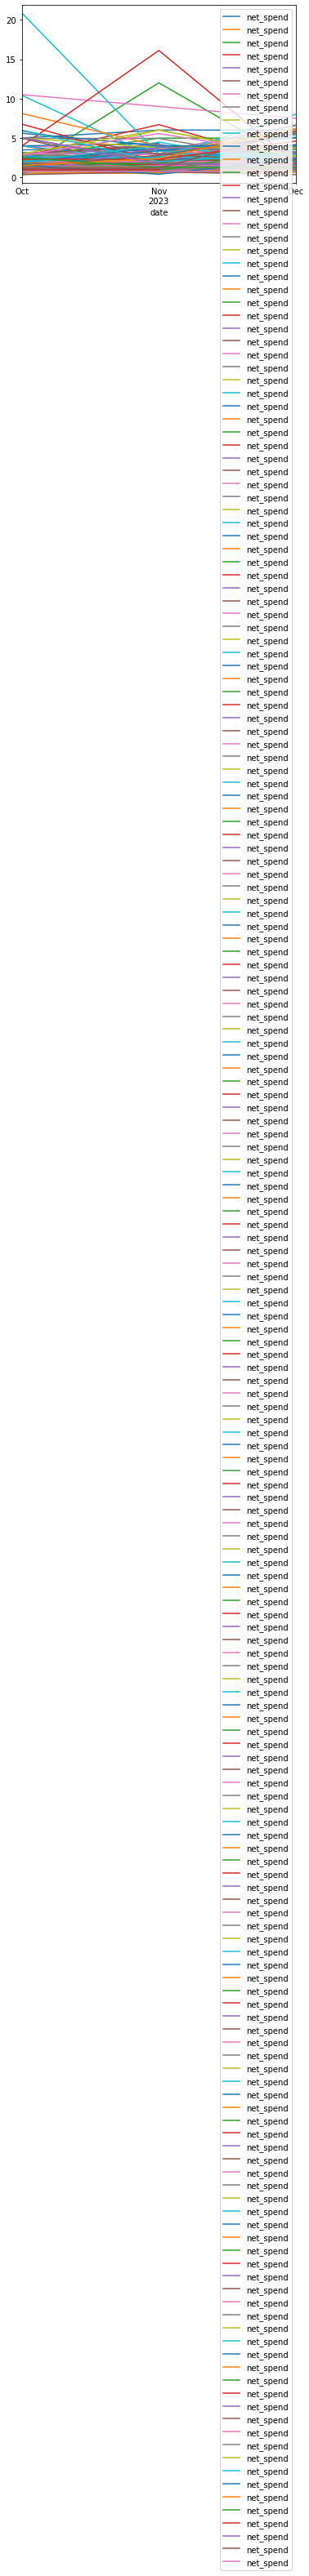

In [ ]:
PRODUCTID = []
RMSE      = []
MSE       = []
FORECAST  = []

for i in tqdm(data.product_id.unique()):
    try:
      ID = data[data.product_id == i][['date', 'net_spend']]
      ID = pd.DataFrame(ID.groupby('date')['net_spend'].first())
      ID = ID.sort_values('date')
      # print("Data Shape: {}".format(ID.shape))
      # ID.head()
      
      # Fit auto_arima function to the dataset
      stepwise_fit = auto_arima(ID.net_spend, start_p = 1, start_q = 1,
                                max_p = 3, max_q = 3, m = 12,
                                start_P = 0, seasonal = False,
                                d = None, D = 1, trace = True,
                                error_action ='ignore',    # we don't want to know if an order does not work
                                suppress_warnings = True,  # we don't want convergence warnings
                                stepwise = True)           # set to stepwise    
      # To print the summary
      # stepwise_fit.summary()

      train = ID[ID.index <= pd.to_datetime("2023-10-01", format='%Y-%m-%d')]
      test  = ID[ID.index >= pd.to_datetime("2023-10-01", format='%Y-%m-%d')]

      model = SARIMAX(train.net_spend, order = (0, 1, 1))
      result = model.fit()
      # result.summary()

      start = len(train)
      end = len(train) + len(test) - 1

      # Predictions for one-year against the test set
      predictions = result.predict(start, end, typ = 'levels').rename("Predictions")
      # plot predictions and actual values
      # predictions.plot(legend = True)
      test.net_spend.plot(legend = True)
      # rmse(test.net_spend, predictions) # Calculate root mean squared error
      # mean_squared_error(test.net_spend, predictions) # Calculate mean squared error

      # Train the model on the full dataset
      model = SARIMAX(ID.net_spend, order = (0, 1, 1))
      result = model.fit()
      # Forecast for the next 3 years
      forecast = result.predict(start = len(ID)-1, end = (len(ID)) + 3 * 1, typ = 'levels').rename('Forecast')
      
      # Plot the forecast values
      # ID.net_spend.plot(figsize = (12, 5), legend = True)
      # forecast.plot(legend = True)
      PRODUCTID.append(i)
      RMSE.append(rmse(test.net_spend, predictions)) # Calculate root mean squared error
      MSE.append(mean_squared_error(test.net_spend, predictions))
      FORECAST.append(forecast)
    except:
      print("ERROR: {}".format(i))

In [ ]:
FinalData = pd.DataFrame({'Product ID': PRODUCTID, 'RMSE': RMSE, 'MSE': MSE,'Forecast':FORECAST})
FinalData.sort_values('Product ID', inplace = True)

In [ ]:
forecast = pd.DataFrame({'Product ID': PRODUCTID, 'Forecast':FORECAST})
forecast.Forecast = forecast.Forecast.apply(lambda x: x.mean())
forecast.sort_values('Forecast', inplace = True)
forecast.head(10)

Product ID  Forecast
158         813  0.600098
2           763  0.700195
162         236  0.720215
130        1365  0.750000
142         456  0.750000
120        1038  0.750000
160        1600  0.750000
168        1630  0.750000
3          1293  0.795207
62          198  0.832104

In [ ]:
pp.ProfileReport(forecast)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fig = px.line(ID, x = ID.index, y = ID.net_spend)
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=700, xaxis_title="Date", yaxis_title="Net Spend", title_text="Net Spend on a Product ID") 
fig.show()

In [ ]:
train = ID[ID.index <= pd.to_datetime("2023-10-01", format='%Y-%m-%d')]
test  = ID[ID.index >= pd.to_datetime("2023-10-01", format='%Y-%m-%d')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train.net_spend, mode='lines+markers', name='Train', line = dict(color='black')))
fig.add_trace(go.Scatter(x=test.index, y=test.net_spend, mode='lines+markers', name='Test', line = dict(color='red')))
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=700, xaxis_title="Date", yaxis_title="Net Spend", title_text="Net Spend on a Product ID") 
fig.show()

## **VISUALIZATION**

In [ ]:
data.corr(method = 'pearson')

customer_id  product_id     month  store_id  \
customer_id                  1.000000   -0.002822  0.000666  0.018358   
product_id                  -0.002822    1.000000  0.005293 -0.019009   
month                        0.000666    0.005293  1.000000 -0.004372   
store_id                     0.018358   -0.019009 -0.004372  1.000000   
units_purchased             -0.008953   -0.030504  0.005940 -0.012090   
volume_purchased            -0.008257    0.038613 -0.001104 -0.008066   
net_spend                    0.004266   -0.069407  0.010856 -0.003875   
units_purchased_on_promo     0.006349   -0.074840 -0.025353 -0.006709   
age                         -0.017075    0.001225 -0.003102  0.059548   
child                        0.004121    0.014957  0.003940 -0.042556   
retired_flag                -0.000614    0.017414  0.003936  0.081585   
income                       0.032341   -0.019160 -0.004134 -0.077409   
brand_id                    -0.002091    0.010103 -0.006429  0.020577   
K_flag                       0.006755    0.065023 -0.001529  0.005517   
store_group                  0.019478    0.014027 -0.005626 -0.065608   
store_size                  -0.011336    0.001489 -0.005528 -0.057362   
revenue                     -0.002061   -0.030616  0.004300  0.003305   

                          units_purchased  volume_purchased  net_spend  \
customer_id                     -0.008953         -0.008257   0.004266   
product_id                      -0.030504          0.038613  -0.069407   
month                            0.005940         -0.001104   0.010856   
store_id                        -0.012090         -0.008066  -0.003875   
units_purchased                  1.000000          0.621279   0.651790   
volume_purchased                 0.621279          1.000000   0.661993   
net_spend                        0.651790          0.661993   1.000000   
units_purchased_on_promo         0.482224          0.265613   0.466381   
age                             -0.010595          0.043895   0.068741   
child                            0.010421         -0.043967  -0.064265   
retired_flag                    -0.017112          0.031568   0.025153   
income                           0.016833          0.000082   0.010429   
brand_id                        -0.007744         -0.001267   0.059195   
K_flag                          -0.038606         -0.019688   0.230503   
store_group                      0.019894         -0.028481  -0.035550   
store_size                       0.019160         -0.029436  -0.011728   
revenue                          0.809092          0.538950   0.723781   

                          units_purchased_on_promo       age     child  \
customer_id                               0.006349 -0.017075  0.004121   
product_id                               -0.074840  0.001225  0.014957   
month                                    -0.025353 -0.003102  0.003940   
store_id                                 -0.006709  0.059548 -0.042556   
units_purchased                           0.482224 -0.010595  0.010421   
volume_purchased                          0.265613  0.043895 -0.043967   
net_spend                                 0.466381  0.068741 -0.064265   
units_purchased_on_promo                  1.000000  0.000795 -0.000882   
age                                       0.000795  1.000000 -0.527369   
child                                    -0.000882 -0.527369  1.000000   
retired_flag                             -0.015615  0.640412 -0.366156   
income                                    0.023160 -0.245503  0.180090   
brand_id                                  0.209366  0.089519 -0.081839   
K_flag                                    0.172550  0.041565 -0.044646   
store_group                               0.044427 -0.068557  0.030831   
store_size                                0.027573 -0.460591  0.777432   
revenue                                   0.514962  0.011295 -0.013716   

                          retired_flag    inc

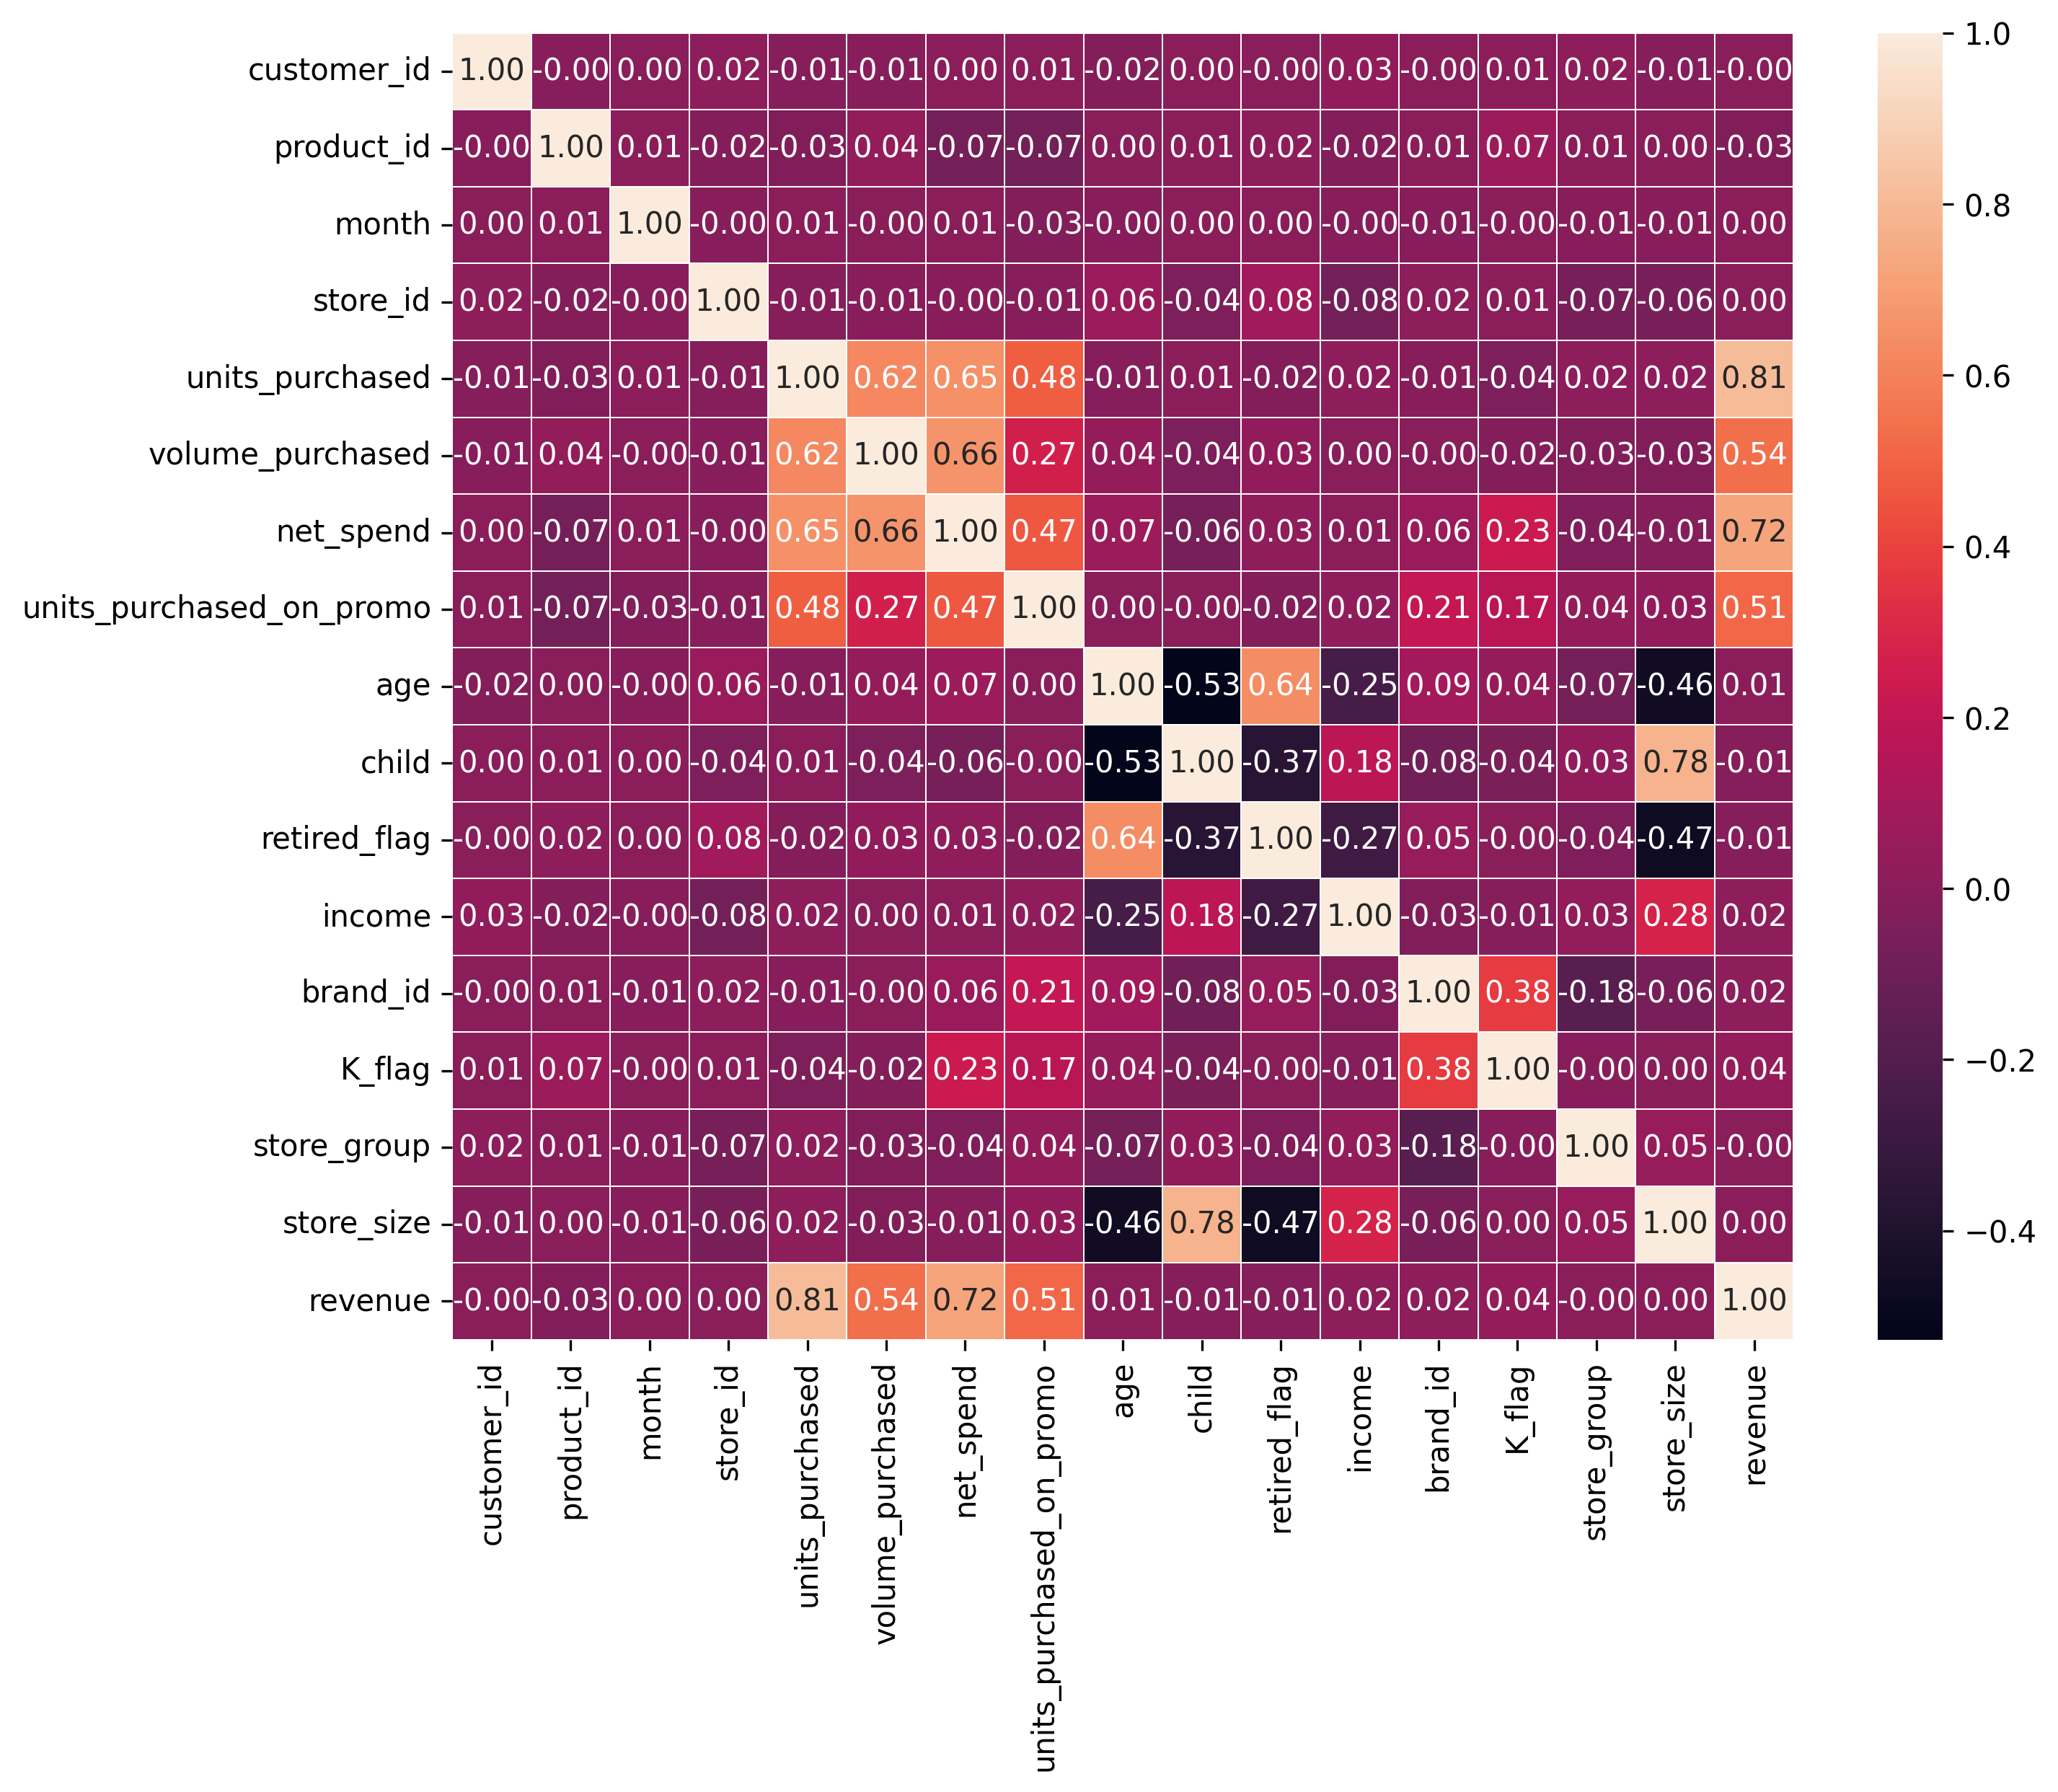

In [ ]:
plt.figure(figsize=(10,8), dpi = 300)
sns.heatmap(data.corr(method = 'pearson'), annot=True, fmt=".2f", linewidth=.1)
plt.show()

In [ ]:
print("We have Records from Date {} to {}".format(data.date.min().date(), data.date.max().date()))

We have Records from Date 2023-01-01 to 2023-12-01


In [ ]:
fig = px.box(data.age, points="outliers")
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=700, width=500, xaxis_title="Age", yaxis_title="Percentile", title_text="Boxplot to Visualize Outliers in Age Feature") 
fig.show()

data = data[data.age < 80]

In [ ]:
fig = px.box(data.income, points="outliers")
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=700, width=500, xaxis_title="Income", yaxis_title="Percentile", title_text="Boxplot to Visualize Outliers in Age Feature") 
fig.show()

In [ ]:
storeGB = pd.DataFrame(data.groupby(['store_id'])['income'].first()).reset_index()
reduce_mem_usage(storeGB)

fig = px.bar(storeGB, x = storeGB.store_id, y = storeGB.income, color = storeGB.income)
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=1400, xaxis_title="Store ID", yaxis_title="Income", title_text="Boxplot to Visualize Customer Income wr.rt. Store ID") 
fig.show()

100%|██████████| 2/2 [00:00<00:00, 547.81it/s]




Memory Usage After Optimization: 0.00 MB
Decreased By: 59.4%



In [ ]:
ageGB = pd.DataFrame(data.groupby(['age'])['income'].first()).reset_index()
reduce_mem_usage(ageGB)

fig = px.bar(ageGB, x = ageGB.age, y = ageGB.income, color = ageGB.income)
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=1600, xaxis_title="Age", yaxis_title="Income", title_text="Barplot to Visualize Customer Income over Different Ages") 
fig.show()

100%|██████████| 2/2 [00:00<00:00, 759.01it/s]



Memory Usage After Optimization: 0.00 MB
Decreased By: 52.8%



In [ ]:
productGB = pd.DataFrame(data.groupby(['product_id'])['income'].first()).reset_index()
reduce_mem_usage(productGB)

fig = px.bar(productGB, x = productGB.product_id, y = productGB.income, color = productGB.income)
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=1600, xaxis_title="Product ID", yaxis_title="Income", title_text="Boxplot to Visualize Income vs Product ID") 
fig.show()

100%|██████████| 2/2 [00:00<00:00, 742.16it/s]



Memory Usage After Optimization: 0.00 MB
Decreased By: 56.4%



In [ ]:
monthGB = pd.DataFrame(data.groupby(['month'])['income'].first()).reset_index()
reduce_mem_usage(monthGB)

fig = px.bar(monthGB, x = monthGB.month, y = monthGB.income, color = monthGB.income)
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=1000, xaxis_title="Month", yaxis_title="Income", title_text="Boxplot to Visualize Income vs Month") 
fig.show()

100%|██████████| 2/2 [00:00<00:00, 569.99it/s]




Memory Usage After Optimization: 0.00 MB
Decreased By: 33.9%



In [ ]:
monthGB = pd.DataFrame(data.groupby(['month'])['revenue'].first()).reset_index()
reduce_mem_usage(monthGB)

fig = px.bar(monthGB, x = monthGB.month, y = monthGB.revenue, color = monthGB.revenue)
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=1000, xaxis_title="Month", yaxis_title="Revenue Generated", title_text="Boxplot to Visualize Revenue Generated Over Different Months") 
fig.show()

100%|██████████| 2/2 [00:00<00:00, 714.05it/s]



Memory Usage After Optimization: 0.00 MB
Decreased By: 33.9%



In [ ]:
print('Out of {} Total Data Size'.format(data.shape[0]))
print('\nThere Are')
print("{} Unique Product ID".format(len(data.product_id.unique())))

print("{} Unique Store ID".format(len(data.store_id.unique())))

print("{} Unique Customer Qualification ID".format(len(data.qualification.unique())))
print("{} Unique Customer Age".format(len(data.age.unique())))

print("{} Unique Store Groups".format(len(data.store_group.unique())))
print("{} Unique Store Sizes".format(len(data.store_size.unique())))

Out of 44158 Total Data Size

There Are
200 Unique Product ID
1049 Unique Store ID
7 Unique Customer Qualification ID
58 Unique Customer Age
57 Unique Store Groups
10 Unique Store Sizes


In [ ]:
data.qualification = data.qualification.replace({'Degree or higher': 0, 
                                                 'GCSE': 1, 
                                                 'Other': 2, 
                                                 'None': 3, 
                                                 'Higher education': 4, 
                                                 'A Level': 5, 
                                                 'Unknown': 6})

data.tenure = data.tenure.replace({'Owned outright': 0, 
                                   'Mortgaged': 1, 
                                   'Rented': 2, 
                                   'Other': 3, 
                                   'Unknown': 4})

data.store_region = data.store_region.replace({'North': 0, 
                                             'London': 1, 
                                             'East': 2, 
                                             'Wales': 3, 
                                             'South': 4, 
                                             'Midlands': 5, 
                                             'Scotland': 6})

reduce_mem_usage(data)

100%|██████████| 21/21 [00:00<00:00, 432.07it/s]



Memory Usage After Optimization: 3.12 MB
Decreased By: 28.4%



In [ ]:
# data = data[['month', 'product_id', 'store_id', 'net_spend', 'qualification', 'tenure', 'retired_flag', 'income','brand_id', 'store_region', 'revenue', 'K_flag']]
data = sales.merge(products, on='product_id', how='left')
reduce_mem_usage(data)

100%|██████████| 10/10 [00:00<00:00, 837.27it/s]



Memory Usage After Optimization: 1.49 MB
Decreased By: 68.9%



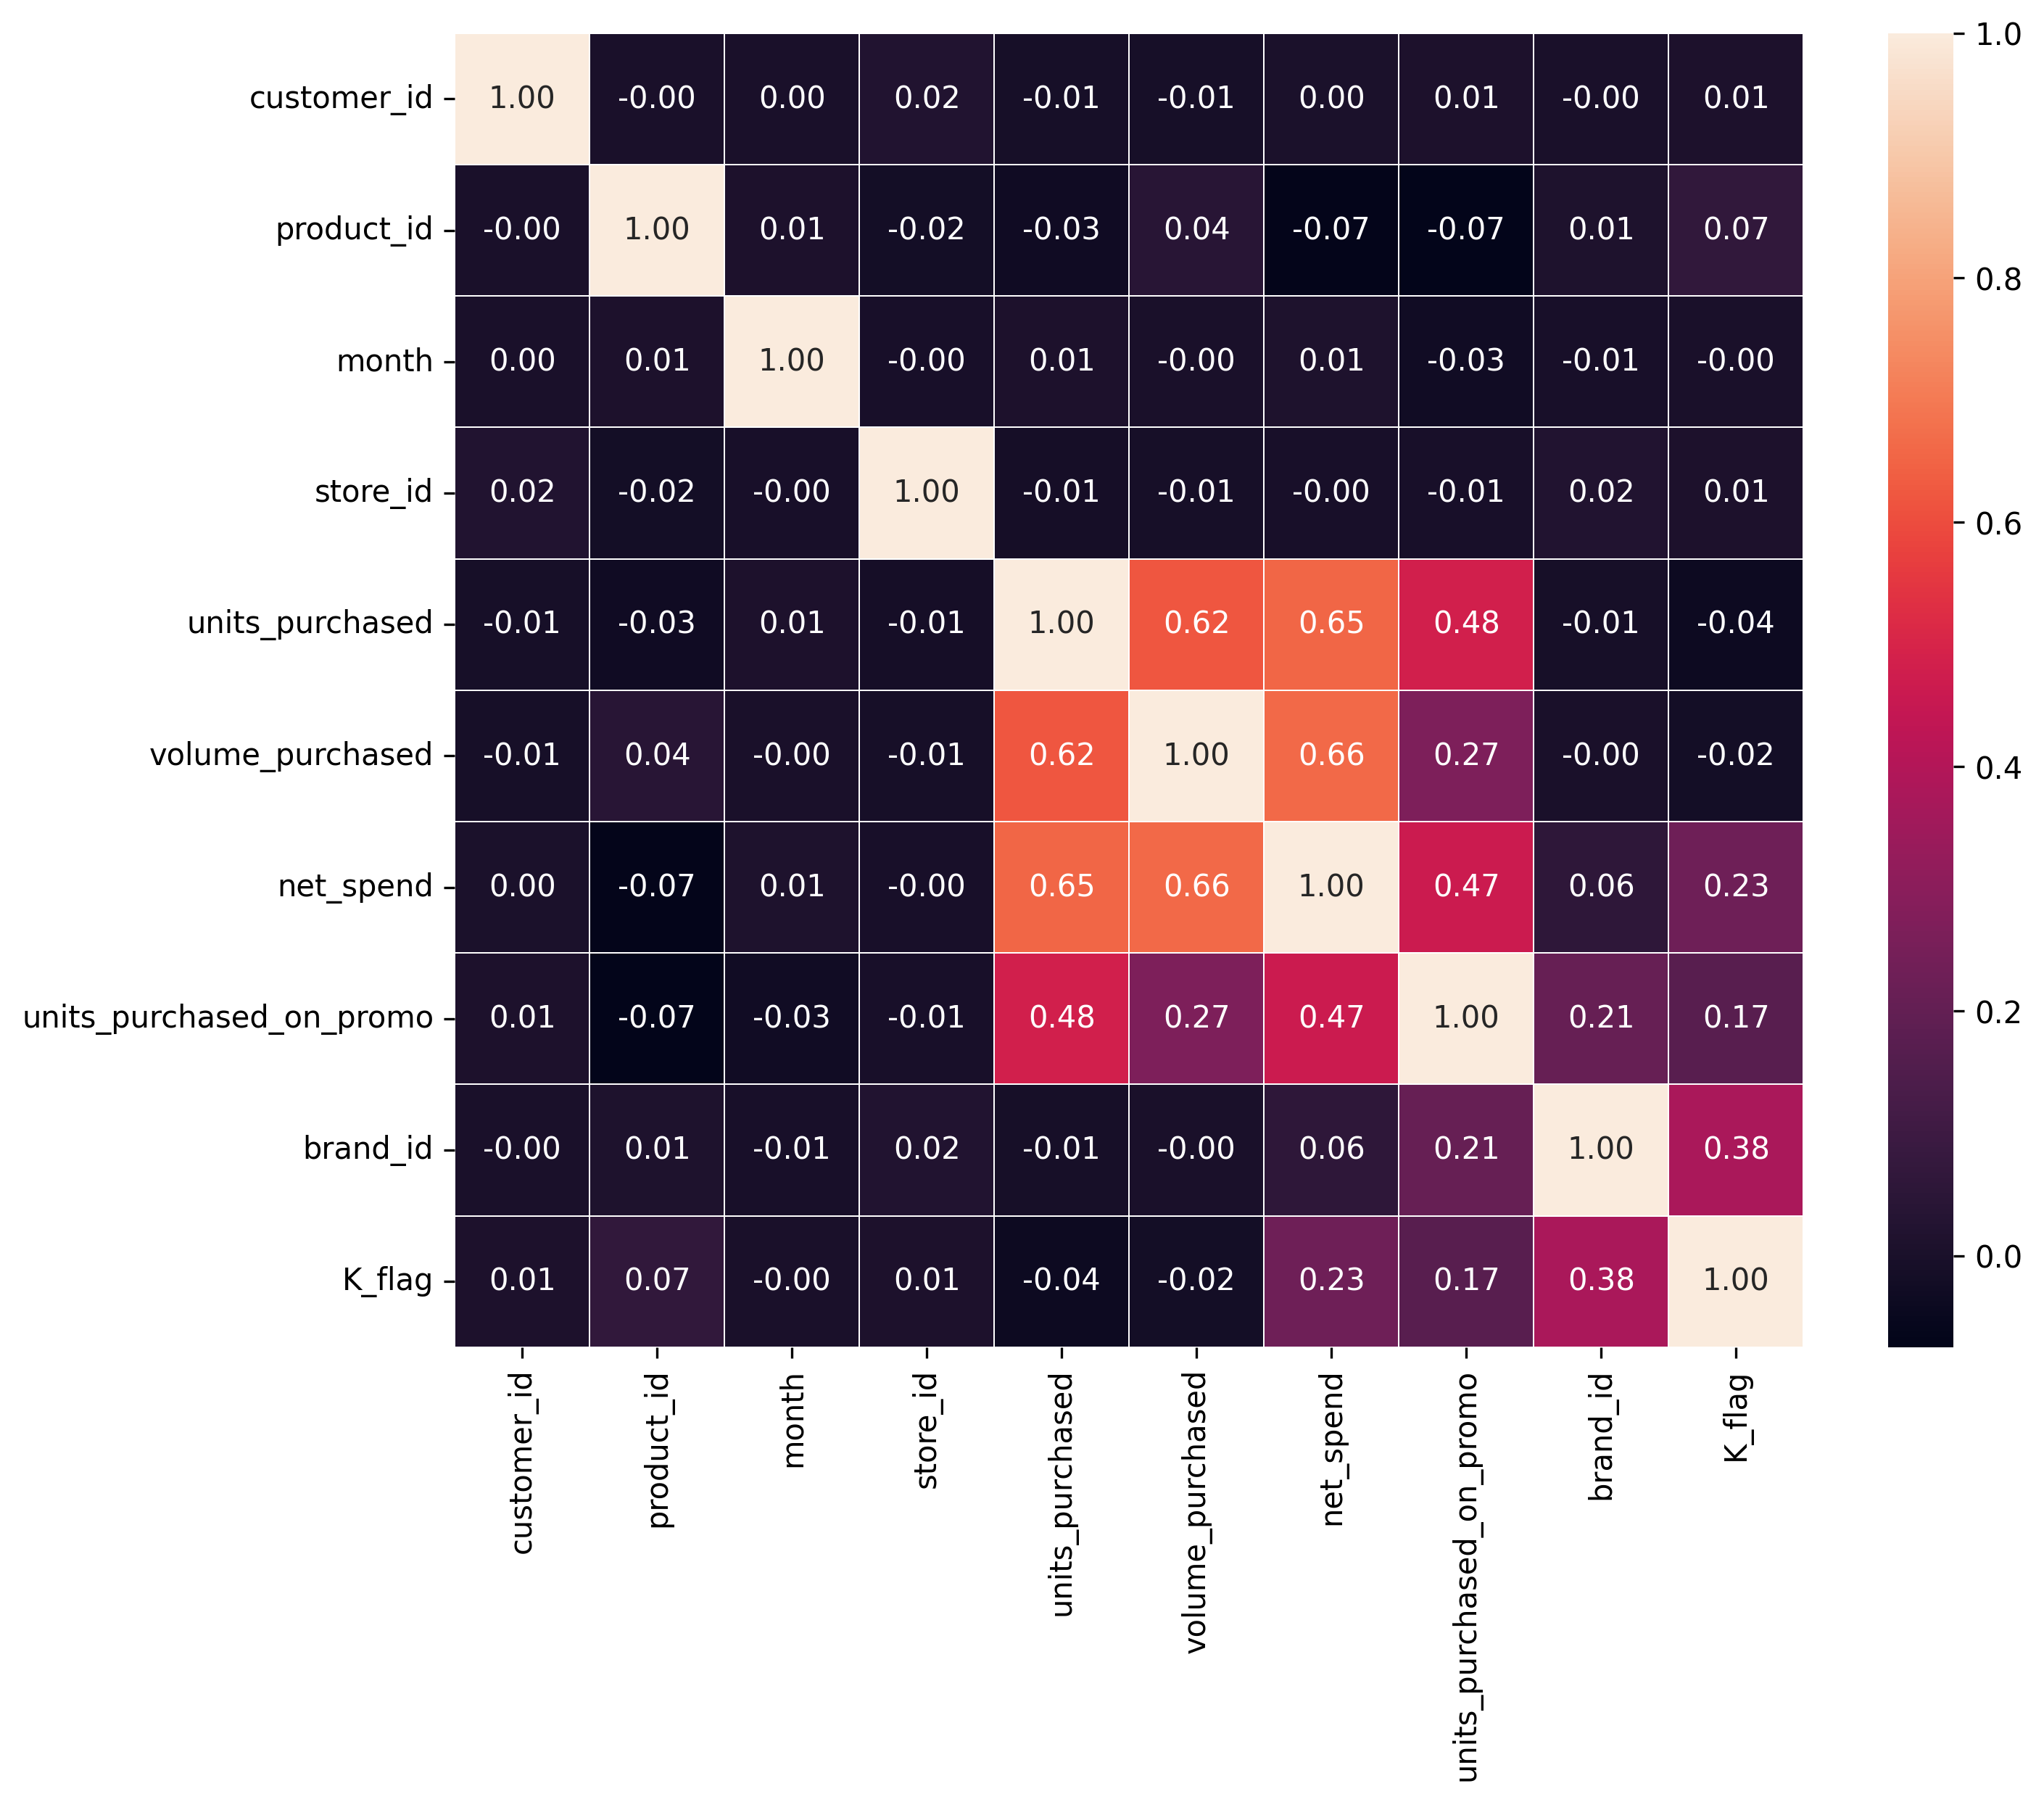

In [ ]:
plt.figure(figsize=(10, 8), dpi = 300)
sns.heatmap(data.corr(method = 'pearson'), annot=True, fmt=".2f", linewidth=.1)
plt.show()

In [ ]:
spend = pd.DataFrame(data.groupby(['month'])['net_spend'].first()).reset_index()

fig = px.bar(spend, x = spend.month, y = spend.net_spend, color = spend.month, barmode = 'group')
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=500, width=1000, xaxis_title="Month", yaxis_title="Net Spend", title_text="Net Spend over Different Months") 
fig.show()

In [ ]:
productSpend = pd.DataFrame(data.groupby(['product_id'])['net_spend'].first()).reset_index()

fig = px.bar(productSpend, x = productSpend.product_id, y = productSpend.net_spend, color = productSpend.product_id, barmode = 'group')
fig.update_xaxes(rangeslider_visible=True, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=600, width=1400, xaxis_title="Month", yaxis_title="Net Spend", title_text="Net Spend over Different Product ID") 
fig.show()

In [ ]:
productSpend = pd.DataFrame(data.groupby(['month', 'product_id'])['net_spend'].first()).reset_index()

fig = px.bar(productSpend, x = productSpend.product_id, y = productSpend.net_spend, animation_frame = productSpend.month, color = productSpend.net_spend, barmode = 'group')
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=600, width=1400, xaxis_title="Month", yaxis_title="Net Spend", title_text="Net Spend For Different Months over a Course of Product ID's") 
fig.show()

In [ ]:
productSpend = pd.DataFrame(data.groupby(['month', 'product_id'])['net_spend'].first()).reset_index()
productSpend = productSpend[productSpend.net_spend < productSpend.net_spend.mean()]

fig = px.bar(productSpend, x = productSpend.month, y = productSpend.net_spend, animation_frame = productSpend.product_id, color = productSpend.net_spend, barmode = 'group')
fig.update_xaxes(rangeslider_visible=False, showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(height=600, width=1400, xaxis_title="Month", yaxis_title="Net Spend", title_text="Net Spend For Different Product ID over a Course of Month") 
fig.show()

## **MODELING**

In [ ]:
X = data[['K_flag', 'customer_id', 'product_id', 'month', 'units_purchased', 'volume_purchased', 'units_purchased_on_promo']]
Y = data['net_spend']

In [ ]:
# Normalize Dataset
scaler = MinMaxScaler()

for col in tqdm(X.columns[5:]):
    X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))

100%|██████████| 2/2 [00:00<00:00, 79.93it/s]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 123)
print('X_train: {}\nX_test : {}\nY_train: {}\nY_test : {}'.format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

X_train: (61322, 7)
X_test : (6814, 7)
Y_train: (61322,)
Y_test : (6814,)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 123)
print('X_train: {}\nX_val  : {}\nY_train: {}\nY_val  : {}'.format(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape))

X_train: (49057, 7)
X_val  : (12265, 7)
Y_train: (49057,)
Y_val  : (12265,)


### **Lasso Regression**

In [ ]:
alpha = [10**i for i in range(-5, 2)]

train_score = []
val_score = []
for i in tqdm(alpha):
    
    print("alpha = {} ".format(i))
    _model = Lasso(alpha= i)
    _model.fit(X_train, Y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20), Y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20), Y_val, squared=False)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss: {} ".format(rmse_train))
    print("Validation Loss: {} ".format(rmse_val))
    print("-"*50)

 29%|██▊       | 2/7 [00:00<00:00, 14.53it/s]

alpha = 1e-05 
Training Loss: 1.047290951701446 
Validation Loss: 1.0270525740201304 
--------------------------------------------------
alpha = 0.0001 
Training Loss: 1.047319280608655 
Validation Loss: 1.0270851709877846 
--------------------------------------------------
alpha = 0.001 
Training Loss: 1.04866866460471 
Validation Loss: 1.0285332501410072 
--------------------------------------------------
alpha = 0.01 


100%|██████████| 7/7 [00:00<00:00, 15.81it/s]

Training Loss: 1.1092861416132316 
Validation Loss: 1.0835754770750188 
--------------------------------------------------
alpha = 0.1 
Training Loss: 1.2396705403326784 
Validation Loss: 1.203265800902879 
--------------------------------------------------
alpha = 1 
Training Loss: 1.607614053083142 
Validation Loss: 1.5773396183769317 
--------------------------------------------------
alpha = 10 
Training Loss: 1.7069958318456382 
Validation Loss: 1.6785636603569953 
--------------------------------------------------


100%|██████████| 7/7 [00:00<00:00, 16.02it/s]


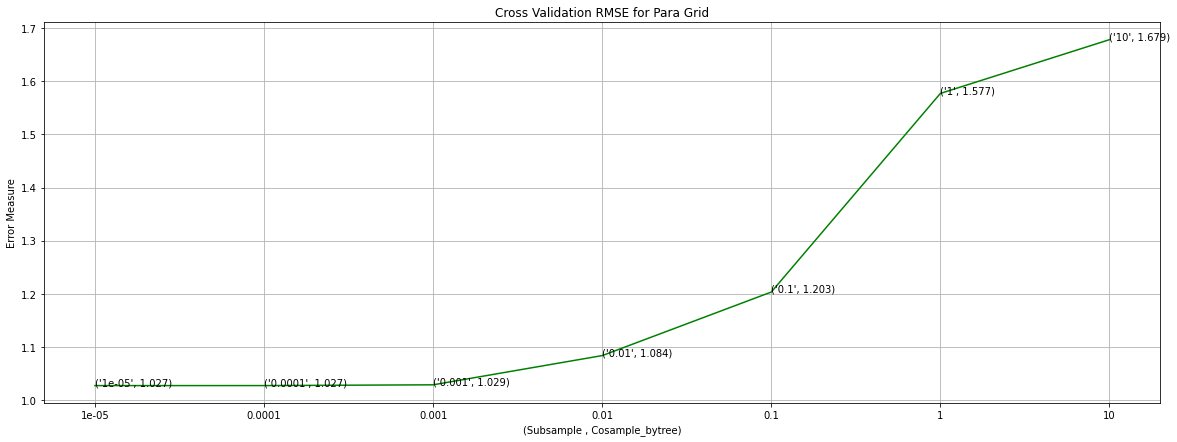

In [ ]:
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(params, val_score, c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))

plt.grid()
plt.title("Cross Validation RMSE for Para Grid")
plt.xlabel("(Subsample , Cosample_bytree)")
plt.ylabel("Error Measure")
plt.show()

### **Ridge Regression**

In [ ]:
alpha = [10**i for i in range(-5, 5)]

train_score = []
val_score = []
for i in tqdm(alpha):
    
    print("alpha = {} ".format(i))
    _model = Ridge(alpha= i)
    _model.fit(X_train, Y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20), Y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20), Y_val, squared=False)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss: {} ".format(rmse_train))
    print("Validation Loss: {} ".format(rmse_val))
    print("-"*50)

 50%|█████     | 5/10 [00:00<00:00, 49.68it/s]

alpha = 1e-05 
Training Loss: 1.047289121999231 
Validation Loss: 1.0270502112297553 
--------------------------------------------------
alpha = 0.0001 
Training Loss: 1.047289128643024 
Validation Loss: 1.0270501986954288 
--------------------------------------------------
alpha = 0.001 
Training Loss: 1.0472891951647796 
Validation Loss: 1.0270500734318526 
--------------------------------------------------
alpha = 0.01 
Training Loss: 1.0472898687605647 
Validation Loss: 1.027048828760784 
--------------------------------------------------
alpha = 0.1 
Training Loss: 1.047297437990521 
Validation Loss: 1.0270371743872058 
--------------------------------------------------
alpha = 1 
Training Loss: 1.0474521005193909 
Validation Loss: 1.0269959055140216 
--------------------------------------------------
alpha = 10 
Training Loss: 1.0535170742026618 
Validation Loss: 1.0313674297106818 
--------------------------------------------------
alpha = 100 
Training Loss: 1.1247116094499896 

100%|██████████| 10/10 [00:00<00:00, 43.26it/s]


Validation Loss: 1.1608332835494979 
--------------------------------------------------
alpha = 10000 
Training Loss: 1.2479247767285373 
Validation Loss: 1.212128718733931 
--------------------------------------------------


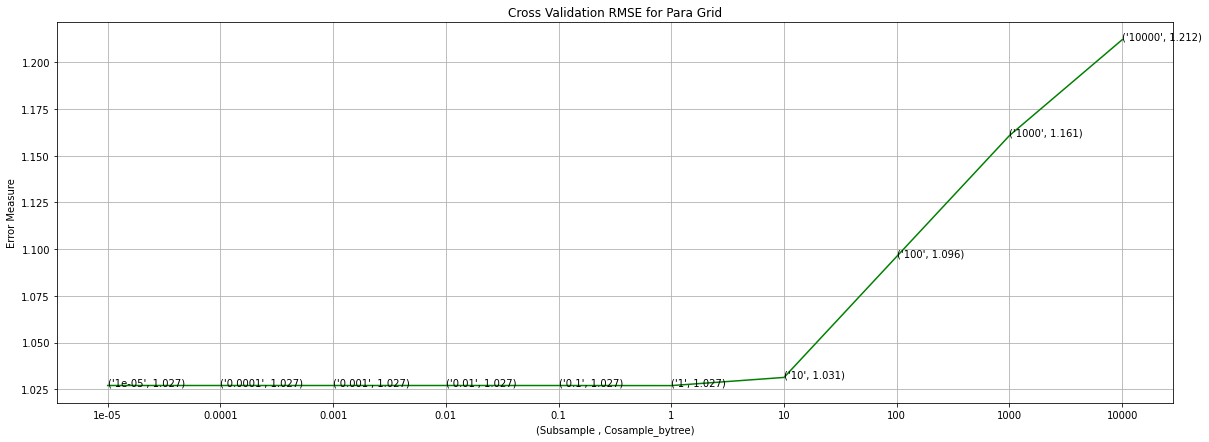

In [ ]:
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(params, val_score, c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))

plt.grid()
plt.title("Cross Validation RMSE for Para Grid")
plt.xlabel("(Subsample , Cosample_bytree)")
plt.ylabel("Error Measure")
plt.show()